# Проект Мастерской "Классификация музыки"

Популярный музыкальный стримминговый сервис "МиФаСоль" расширяет работу с новыми артистами и музыкантами, в связи с чем возникла задача - правильно классифицировать новые музыкальные треки, чтобы улучшить работу рекомендательной системы. Сотрудники отдела работы со звуком подготовили датасет, в котором собраны некоторые характеристики музыкальных произведений и их жанры. Задача - разработать модель, позволяющую классифицировать музыкальные произведения по жанрам.

**Основные этапы исследования:**

1) Загрузка и ознакомление с данными \
2) Предварительная обработка \
3) Исследовательский анализ данных \
4) Выбор и обучение моделей \
5) Итоговая оценка качества предсказания лучшей модели и анализ важности ее признаков \
6) Общий вывод

Импортируем полезные библиотеки, которые пригодятся нам в будущем

In [4]:
import numpy as np
import pandas as pd
import deezer
from collections import Counter
from math import floor, ceil
from tqdm import tqdm
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from sklearn.preprocessing import OrdinalEncoder
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import fbeta_score, roc_curve, roc_auc_score

Зададим параметры по умолчанию и объявим константы, которые понадобятся нам в дальнейшем

In [5]:
RANDOM_STATE = 510466
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 4)
plt.rcParams["figure.figsize"] = (18, 12)
display(HTML("<style>.container {width:75% !important;}</style>"))
deezer_client = deezer.Client(headers={'Accept-Language': 'en'})
tqdm.pandas()

## Загрузка и ознакомление с данными

### Получим данные с информацией о музыкальных треках и сохраним их в соответсвующие переменные

In [6]:
train_data = pd.read_csv('./kaggle_music_genre_train.csv')
test_data = pd.read_csv('./kaggle_music_genre_test.csv')

### Ознакомимся с тренировочным набором данных. Выведем несколько строк из датафрейма, взятых случайным образом:

In [7]:
train_data.sample(10, random_state=RANDOM_STATE)

,instance_id,track_name,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre
14990,24783.0,On the River,0.4760,0.8640,-1.0,0.3900,0.0000e+00,C,0.0954,-5.541,Major,0.1280,139.996,4-Apr,0.1050,Rap
10505,41282.0,Make It Sweet,0.0317,0.5390,-1.0,0.8590,0.0000e+00,G,0.1020,-4.465,Major,0.0399,89.937,4-Apr,0.4560,Country
7883,41501.0,Closure,0.0009,0.2890,251800.0,0.7360,3.9500e-03,B,0.0636,-3.380,Minor,0.0369,152.158,3-Apr,0.1300,Rap
12753,52043.0,Noise Machine,0.9560,0.4820,293253.0,0.2230,4.3500e-02,A#,0.0872,-13.864,Minor,0.0401,157.131,4-Apr,0.2950,Classical
18398,26819.0,"Love, Love, Love",0.6830,0.4970,204056.0,0.6360,0.0000e+00,G#,0.2280,-8.710,Major,0.0723,93.777,4-Apr,0.6900,Jazz
16356,86807.0,When I'm Small,0.1910,0.6460,249067.0,0.7580,9.7000e-02,A#,0.1030,-4.340,Major,0.0314,91.998,4-Apr,0.4240,Alternative
15504,86808.0,Look Alive (feat. Drake),0.0010,0.9220,181263.0,0.5810,5.8600e-05,A#,0.1050,-7.495,Major,0.2700,140.022,4-Apr,0.5950,Rap
10246,72526.0,Opium Trail,0.1710,0.2940,235013.0,0.7740,1.0000e-04,F,0.1500,-11.670,Minor,0.0737,170.217,4-Apr,0.7120,Blues
18201,21571.0,Lux aeterna,0.9620,0.0663,-1.0,0.0029,5.6900e-01,D#,0.0893,-40.694,Major,0.0486,75.787,3-Apr,0.0193,Classical
453,39316.0,When I Paint My Masterpiece - Remastered 2000,0.0367,0.4950,261267.0,0.7140,0.0000e+00,A#,0.4630,-8.270,Major,0.0341,132.434,4-Apr,0.5320,Blues


### Отобразим информацию для краткого обзора тренировочного набора данных:

In [8]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20394 entries, 0 to 20393
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   instance_id       20394 non-null  float64
 1   track_name        20394 non-null  object 
 2   acousticness      20394 non-null  float64
 3   danceability      20394 non-null  float64
 4   duration_ms       20394 non-null  float64
 5   energy            20394 non-null  float64
 6   instrumentalness  20394 non-null  float64
 7   key               19659 non-null  object 
 8   liveness          20394 non-null  float64
 9   loudness          20394 non-null  float64
 10  mode              19888 non-null  object 
 11  speechiness       20394 non-null  float64
 12  tempo             19952 non-null  float64
 13  obtained_date     20394 non-null  object 
 14  valence           20394 non-null  float64
 15  music_genre       20394 non-null  object 
dtypes: float64(11), object(5)
memory usage: 

### Отобразим таблицу с описательной статистикой признаков для тренировочного набора данных:

In [9]:
train_data.describe()

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
count,20394.0000,20394.0000,20394.0000,2.0394e+04,20394.0000,20394.0000,20394.0000,20394.0000,20394.0000,19952.0000,20394.0000
mean,55973.8469,0.2748,0.5620,2.2038e+05,0.6253,0.1600,0.1985,-8.5530,0.0914,120.9425,0.4646
std,20695.7925,0.3216,0.1719,1.2673e+05,0.2512,0.3065,0.1667,5.4999,0.0977,30.4276,0.2434
min,20011.0000,0.0000,0.0600,-1.0000e+00,0.0010,0.0000,0.0136,-44.4060,0.0223,34.7650,0.0000
25%,38157.2500,0.0152,0.4510,1.7752e+05,0.4700,0.0000,0.0973,-10.2557,0.0356,95.9218,0.2720
50%,56030.0000,0.1200,0.5700,2.1953e+05,0.6660,0.0001,0.1300,-7.0520,0.0490,120.0125,0.4570
75%,73912.7500,0.4700,0.6830,2.6600e+05,0.8300,0.0845,0.2530,-5.0540,0.0956,141.9663,0.6530
max,91758.0000,0.9960,0.9780,4.4980e+06,0.9990,0.9960,1.0000,3.7440,0.9420,220.0410,0.9920


### Отобразим таблицу с попарными корреляциями признаков для тренировочного набора данных:

In [10]:
train_data.corr().style.background_gradient(axis=None, cmap='Blues')  

,instance_id,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
instance_id,1.0000,0.0039,-0.0009,-0.0028,0.0048,0.0098,0.0023,-0.0001,-0.0134,-0.0111,0.0002
acousticness,0.0039,1.0000,-0.2734,0.0438,-0.7649,0.3168,-0.0918,-0.6997,-0.1446,-0.2148,-0.2217
danceability,-0.0009,-0.2734,1.0000,-0.1453,0.1827,-0.2538,-0.0808,0.3172,0.2580,-0.0598,0.3902
duration_ms,-0.0028,0.0438,-0.1453,1.0000,-0.0555,0.1415,0.0370,-0.0969,-0.0827,-0.0417,-0.1270
energy,0.0048,-0.7649,0.1827,-0.0555,1.0000,-0.3200,0.1768,0.8218,0.1505,0.2506,0.3480
instrumentalness,0.0098,0.3168,-0.2538,0.1415,-0.3200,1.0000,-0.0638,-0.4814,-0.1770,-0.0954,-0.2600
liveness,0.0023,-0.0918,-0.0808,0.0370,0.1768,-0.0638,1.0000,0.1066,0.0986,0.0389,0.0372
loudness,-0.0001,-0.6997,0.3172,-0.0969,0.8218,-0.4814,0.1066,1.0000,0.1521,0.2205,0.2840
speechiness,-0.0134,-0.1446,0.2580,-0.0827,0.1505,-0.1770,0.0986,0.1521,1.0000,0.0644,0.0316
tempo,-0.0111,-0.2148,-0.0598,-0.0417,0.2506,-0.0954,0.0389,0.2205,0.0644,1.0000,0.0856


### Отобразим гистограммы распределений значений признаков для тренировочного набора данных:

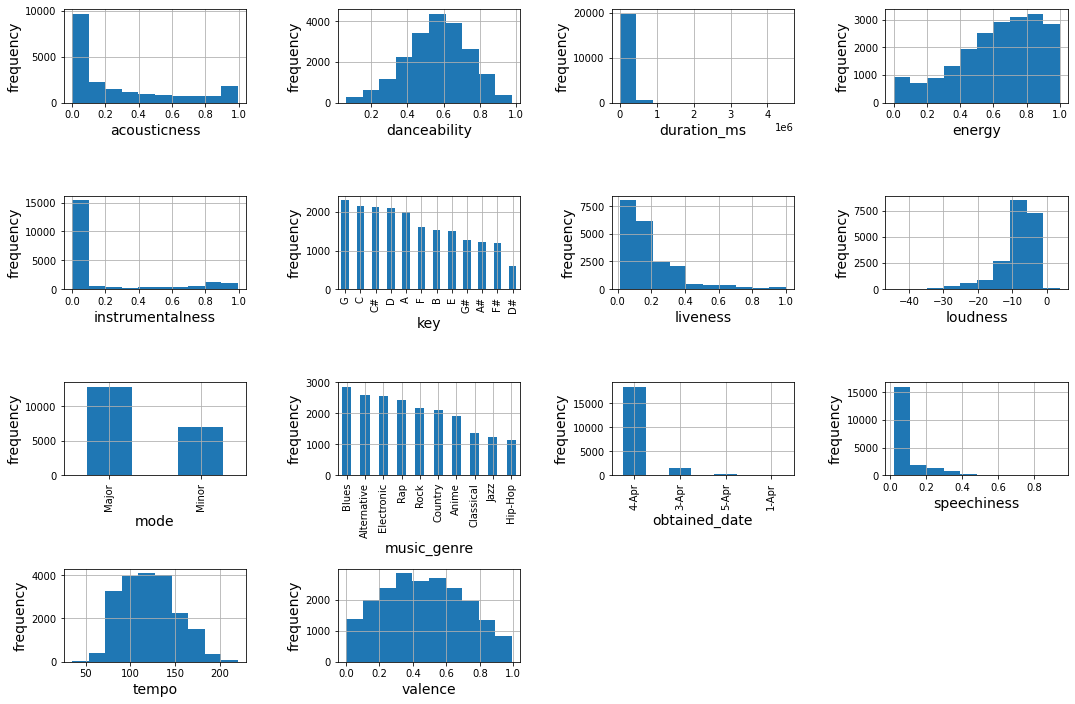

In [12]:
fig = plt.figure()
plt.subplots_adjust(wspace=0.5, hspace=1.0)

for i, col in enumerate(train_data.columns.difference(['instance_id', 'track_name'])):
    ax = fig.add_subplot(4, 4, i + 1)

    # Отобразим количественные и категориальные переменные соответствующими методами
    if np.issubdtype(train_data[col].dtype, np.number):
        train_data[col].plot(kind='hist')
    else:
        train_data[col].value_counts().plot(kind='bar')
        
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('frequency', fontsize=14)
    ax.grid(visible=True)

### Краткий вывод:

- в данных отсутствуют нарушения правила хорошего стиля в названии столбцов
- в данных присутствуют несоответствия типов в столбцах `instance_id` и `duration_ms`. Исправим их на этапе предобработки данных
- в данных присутствуют явные пропуски в столбцах `key`, `mode`, `tempo`. Также в столбце `duration_ms` можно обнаружить пропуски в неявном виде со значением $-1.0$
- в данных присутствуют намёки на мультиколлинеарность. Например, коэффициент корреляции между признаками `loudness` и `energy` равен $0.8218$
- мелодии в большинстве музыкальных треков написаны в мажорном (`Major`) ладу

## Предварительная обработка

### Объявим дополнительные функции, которые понадобятся нам в дальнейшем

In [13]:
# Функция genre_from_name возвращает жанр, который содержится в названии музыкального трека в качестве подстроки
def genre_from_name(row):
    for genre in train_data.music_genre.unique():
        if genre.lower() in row.track_name.lower().split():
            return genre
        
    return None

# Функция genre_from_deezer возвращает жанр из поиска музыкальной библиотеки deezer по названию музыкального трека
def genre_from_deezer(row):
    try:
        genre_occurencies = Counter()
        tracks = deezer_client.search(track=row.track_name, dur_min=floor(row.duration_ms / 1000), dur_max=ceil(row.duration_ms / 1000))

        for track in tracks:
            if row.track_name.lower() in track.title.lower():
                genre_occurencies.update([deezer_client.get_genre(track.album.genre_id).name])
                
        return max(genre_occurencies, key=genre_occurencies.get)
    except:
        return None

### Исправим несоответсвтия типов в данных

In [14]:
train_data = train_data.astype({'instance_id': 'int64', 'duration_ms': 'int64'})
test_data = test_data.astype({'instance_id': 'int64', 'duration_ms': 'int64'})

### Добавим дополнительные признаки

Признак `track_name` в изначальном виде не очень полезен для прогнозирования музыкального жанра. Но из него можно сконструировать другие полезные признаки. Вот несколько вариантов как это можно сделать:

1) Название трека может содержать жанр как подстроку. Например трек с названием `Blues for Mama` содержит подстроку `Blues` \
2) По названию трека можно определить жанр при помощи поиска в музыкальных библиотеках, например через `Spotify API`, `Last.fm API`, `Shazam API`, `deezer API`, `Apple Music API`, `MusicBrainz API` и т.д.

К сожалению `Spotify API` не может быть использован для машинного обучения из-за ограничений в правилах пользования. (`Spotify content may not be used to train machine learning or AI model`) А `Last.fm API` содержит в себе кучу мусорных тегов. Проще всего удалось реализовать поиск при помощи `deezer API`. Будем пользоватся только этим ресурсом. Создадим новые признаки на основе этих двух вариантов

In [ ]:
train_data['genre_from_name'] = train_data.progress_apply(genre_from_name, axis=1).fillna(np.nan)
test_data['genre_from_name'] = test_data.progress_apply(genre_from_name, axis=1).fillna(np.nan)

train_data['genre_from_deezer'] = train_data.progress_apply(genre_from_deezer, axis=1).fillna(np.nan)
test_data['genre_from_deezer'] = test_data.progress_apply(genre_from_deezer, axis=1).fillna(np.nan)

Теперь удалим неинформативные признаки, которые не несут ценности для прогноза:
- признак `instance_id` никак не связан с целевым признаком `music_genre`
- признак `track_name` сам по себе не очень полезен для прогнозирования целевого признака `music_genre`

In [16]:
train_data.drop(['instance_id', 'track_name'], inplace=True, axis=1, errors='ignore')
test_data.drop(['instance_id', 'track_name'], inplace=True, axis=1, errors='ignore')

### Закодируем категориальные переменные

Будем использовать метод `OrdinalEncoding` и в будущем учтём, что линейные модели плохо работают с таким методом кодирования

In [17]:
categorical = ['key', 'mode', 'obtained_date', 'genre_from_name', 'genre_from_deezer']
encoder = OrdinalEncoder(encoded_missing_value=np.nan, handle_unknown='use_encoded_value', unknown_value=np.nan)
encoder.fit(train_data[categorical])

train_data[categorical] = pd.DataFrame(encoder.transform(train_data[categorical]), index=train_data[categorical].index)
test_data[categorical] = pd.DataFrame(encoder.transform(test_data[categorical]), index=test_data[categorical].index)

### Очистим данные от пропусков

Посчитаем количество пропусков для каждого столбца

In [18]:
train_data.isna().sum()

acousticness             0
danceability             0
duration_ms              0
energy                   0
instrumentalness         0
key                    735
liveness                 0
loudness                 0
mode                   506
speechiness              0
tempo                  442
obtained_date            0
valence                  0
music_genre              0
genre_from_name      20117
genre_from_deezer    11854
dtype: int64

- заполним пропуски в категориальных признаках `genre_from_name` и `genre_from_deezer` константным значением $-1.0$
- заполним пропуски в категориальных признаках `key`, `mode` алгоритмом ближайшего соседа с параметром $n\_neighbors = 1$ для того, чтобы не получить дробные значения
- заполним пропуски в количественных признаках `duration_ms` и `tempo` при помощи того же самого алгоритма ближайшего соседа

In [19]:
train_data.loc[train_data.duration_ms < 0, 'duration_ms'] = np.nan
test_data.loc[test_data.duration_ms < 0, 'duration_ms'] = np.nan

simple_columns = ['genre_from_name', 'genre_from_deezer']
simple_imputer = SimpleImputer(strategy='constant', fill_value=-1.0)
simple_imputer.fit(train_data[simple_columns])
train_data[simple_columns] = pd.DataFrame(simple_imputer.transform(train_data[simple_columns]), index=train_data[simple_columns].index)
test_data[simple_columns] = pd.DataFrame(simple_imputer.transform(test_data[simple_columns]), index=test_data[simple_columns].index)

knn_columns = train_data.columns.difference(simple_columns + ['music_genre'])
knn_imputer = KNNImputer(n_neighbors=1)
knn_imputer.fit(train_data[knn_columns])
train_data[knn_columns] = pd.DataFrame(knn_imputer.transform(train_data[knn_columns]), index=train_data[knn_columns].index)
test_data[knn_columns] = pd.DataFrame(knn_imputer.transform(test_data[knn_columns]), index=test_data[knn_columns].index)

Снова посчитаем количество пропусков для каждого столбца

In [20]:
train_data.isna().sum()

acousticness         0
danceability         0
duration_ms          0
energy               0
instrumentalness     0
key                  0
liveness             0
loudness             0
mode                 0
speechiness          0
tempo                0
obtained_date        0
valence              0
music_genre          0
genre_from_name      0
genre_from_deezer    0
dtype: int64

### Очистим данные от дубликатов

Удалим из данных полные дубликаты

In [21]:
print('Количество полных дубликатов до удаления:', train_data[train_data.duplicated()].size)
train_data = train_data.drop_duplicates().reset_index(drop=True)
print('Количество полных дубликатов после удаления:', train_data[train_data.duplicated()].size)

Количество полных дубликатов до удаления: 48
Количество полных дубликатов после удаления: 0


Попробуем найти неполные дубликаты в данных

In [22]:
duplicated = train_data.duplicated(subset=['duration_ms', 'key', 'mode', 'tempo', 'loudness'], keep=False)
train_data[duplicated].sort_values(by='tempo').head(10)

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,obtained_date,valence,music_genre,genre_from_name,genre_from_deezer
11297,0.0319,0.680,273547.0,0.613,0.2360,4.0,0.0730,-5.959,0.0,0.0612,58.099,2.0,0.6230,Electronic,-1.0,9.0
2760,0.0319,0.680,273547.0,0.613,0.2360,4.0,0.0730,-5.959,0.0,0.0612,58.099,2.0,0.6230,Alternative,-1.0,9.0
11594,0.4730,0.519,207547.0,0.320,0.8460,0.0,0.1100,-11.238,1.0,0.0293,60.933,2.0,0.0517,Jazz,-1.0,-1.0
8211,0.4730,0.519,207547.0,0.320,0.8460,0.0,0.1100,-11.238,1.0,0.0293,60.933,2.0,0.0517,Electronic,-1.0,18.0
1915,0.4820,0.535,201000.0,0.425,0.0003,3.0,0.0842,-8.392,0.0,0.0292,64.712,2.0,0.2390,Rock,-1.0,-1.0
11264,0.4820,0.535,201000.0,0.425,0.0003,3.0,0.0842,-8.392,0.0,0.0292,64.712,2.0,0.2390,Blues,-1.0,-1.0
18663,0.1660,0.567,321080.0,0.309,0.0000,11.0,0.1200,-14.254,0.0,0.3850,65.041,2.0,0.5090,Rap,-1.0,20.0
3272,0.1660,0.567,321080.0,0.309,0.0000,11.0,0.1200,-14.254,0.0,0.3850,65.041,2.0,0.5090,Hip-Hop,-1.0,20.0
11029,0.9820,0.144,279560.0,0.079,0.8980,1.0,0.4020,-22.993,1.0,0.0363,65.630,2.0,0.2450,Classical,-1.0,-1.0
11632,0.9820,0.144,279560.0,0.079,0.8980,1.0,0.4020,-22.993,1.0,0.0363,65.630,2.0,0.2450,Anime,-1.0,-1.0


Самый простой способ избавиться от таких дубликатов — из нескольких строк-дубликатов отставить только первую. Более продвинутый вариант — обучить простой алгоритм классификации, чтобы спрогнозировать какая из строк-дубликатов наиболее правдободобна и оставить только её. Обучим алгоритм `DecisionTreeClassifier` на данных без дубликатов, а затем спрогнозируем — какую из строк дубликатов лучше удалить, а какую оставить

In [ ]:
estimator = GridSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                         param_grid={
                             'criterion': ['gini', 'entropy'],
                             'max_depth': list(range(1, 51)),
                             'min_samples_split': list(range(2, 12))
                         },
                         n_jobs=-1,
                         cv=5,
                         verbose=10).fit(train_data[~duplicated].drop(['music_genre'], axis=1), 
                                         train_data.loc[~duplicated, 'music_genre']).best_estimator_

Fitting 5 folds for each of 1000 candidates, totalling 5000 fits
[CV 1/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 1/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.104 total time=   0.1s
[CV 2/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 2/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.103 total time=   0.1s
[CV 3/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 3/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.103 total time=   0.1s
[CV 4/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 4/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.103 total time=   0.1s
[CV 5/5; 1/1000] START criterion=gini, max_depth=1, min_samples_split=2.........
[CV 5/5; 1/1000] END criterion=gini, max_depth=1, min_samples_split=2;, score=0.105 total time=   0.1s
[CV 1/5; 2/1000

[CV 2/5; 10/1000] END criterion=gini, max_depth=1, min_samples_split=11;, score=0.103 total time=   0.1s
[CV 3/5; 10/1000] START criterion=gini, max_depth=1, min_samples_split=11.......
[CV 3/5; 10/1000] END criterion=gini, max_depth=1, min_samples_split=11;, score=0.103 total time=   0.1s
[CV 4/5; 10/1000] START criterion=gini, max_depth=1, min_samples_split=11.......
[CV 4/5; 10/1000] END criterion=gini, max_depth=1, min_samples_split=11;, score=0.103 total time=   0.1s
[CV 5/5; 10/1000] START criterion=gini, max_depth=1, min_samples_split=11.......
[CV 5/5; 10/1000] END criterion=gini, max_depth=1, min_samples_split=11;, score=0.105 total time=   0.1s
[CV 1/5; 11/1000] START criterion=gini, max_depth=2, min_samples_split=2........
[CV 1/5; 11/1000] END criterion=gini, max_depth=2, min_samples_split=2;, score=0.193 total time=   0.1s
[CV 2/5; 11/1000] START criterion=gini, max_depth=2, min_samples_split=2........
[CV 2/5; 11/1000] END criterion=gini, max_depth=2, min_samples_split=2;

[CV 2/5; 19/1000] END criterion=gini, max_depth=2, min_samples_split=10;, score=0.181 total time=   0.1s
[CV 3/5; 19/1000] START criterion=gini, max_depth=2, min_samples_split=10.......
[CV 3/5; 19/1000] END criterion=gini, max_depth=2, min_samples_split=10;, score=0.180 total time=   0.1s
[CV 4/5; 19/1000] START criterion=gini, max_depth=2, min_samples_split=10.......
[CV 4/5; 19/1000] END criterion=gini, max_depth=2, min_samples_split=10;, score=0.185 total time=   0.1s
[CV 5/5; 19/1000] START criterion=gini, max_depth=2, min_samples_split=10.......
[CV 5/5; 19/1000] END criterion=gini, max_depth=2, min_samples_split=10;, score=0.179 total time=   0.1s
[CV 1/5; 20/1000] START criterion=gini, max_depth=2, min_samples_split=11.......
[CV 1/5; 20/1000] END criterion=gini, max_depth=2, min_samples_split=11;, score=0.193 total time=   0.1s
[CV 2/5; 20/1000] START criterion=gini, max_depth=2, min_samples_split=11.......
[CV 2/5; 20/1000] END criterion=gini, max_depth=2, min_samples_split=1

[CV 4/5; 28/1000] END criterion=gini, max_depth=3, min_samples_split=9;, score=0.277 total time=   0.1s
[CV 5/5; 28/1000] START criterion=gini, max_depth=3, min_samples_split=9........
[CV 5/5; 28/1000] END criterion=gini, max_depth=3, min_samples_split=9;, score=0.273 total time=   0.1s
[CV 1/5; 29/1000] START criterion=gini, max_depth=3, min_samples_split=10.......
[CV 1/5; 29/1000] END criterion=gini, max_depth=3, min_samples_split=10;, score=0.280 total time=   0.1s
[CV 2/5; 29/1000] START criterion=gini, max_depth=3, min_samples_split=10.......
[CV 2/5; 29/1000] END criterion=gini, max_depth=3, min_samples_split=10;, score=0.271 total time=   0.1s
[CV 3/5; 29/1000] START criterion=gini, max_depth=3, min_samples_split=10.......
[CV 3/5; 29/1000] END criterion=gini, max_depth=3, min_samples_split=10;, score=0.280 total time=   0.1s
[CV 4/5; 29/1000] START criterion=gini, max_depth=3, min_samples_split=10.......
[CV 4/5; 29/1000] END criterion=gini, max_depth=3, min_samples_split=10;

[CV 4/5; 37/1000] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.316 total time=   0.1s
[CV 5/5; 37/1000] START criterion=gini, max_depth=4, min_samples_split=8........
[CV 5/5; 37/1000] END criterion=gini, max_depth=4, min_samples_split=8;, score=0.312 total time=   0.1s
[CV 1/5; 38/1000] START criterion=gini, max_depth=4, min_samples_split=9........
[CV 1/5; 38/1000] END criterion=gini, max_depth=4, min_samples_split=9;, score=0.291 total time=   0.1s
[CV 2/5; 38/1000] START criterion=gini, max_depth=4, min_samples_split=9........
[CV 2/5; 38/1000] END criterion=gini, max_depth=4, min_samples_split=9;, score=0.316 total time=   0.1s
[CV 3/5; 38/1000] START criterion=gini, max_depth=4, min_samples_split=9........
[CV 3/5; 38/1000] END criterion=gini, max_depth=4, min_samples_split=9;, score=0.320 total time=   0.1s
[CV 4/5; 38/1000] START criterion=gini, max_depth=4, min_samples_split=9........
[CV 4/5; 38/1000] END criterion=gini, max_depth=4, min_samples_split=9;, sc

[CV 5/5; 46/1000] END criterion=gini, max_depth=5, min_samples_split=7;, score=0.348 total time=   0.1s
[CV 1/5; 47/1000] START criterion=gini, max_depth=5, min_samples_split=8........
[CV 1/5; 47/1000] END criterion=gini, max_depth=5, min_samples_split=8;, score=0.338 total time=   0.1s
[CV 2/5; 47/1000] START criterion=gini, max_depth=5, min_samples_split=8........
[CV 2/5; 47/1000] END criterion=gini, max_depth=5, min_samples_split=8;, score=0.328 total time=   0.1s
[CV 3/5; 47/1000] START criterion=gini, max_depth=5, min_samples_split=8........
[CV 3/5; 47/1000] END criterion=gini, max_depth=5, min_samples_split=8;, score=0.334 total time=   0.1s
[CV 4/5; 47/1000] START criterion=gini, max_depth=5, min_samples_split=8........
[CV 4/5; 47/1000] END criterion=gini, max_depth=5, min_samples_split=8;, score=0.337 total time=   0.1s
[CV 5/5; 47/1000] START criterion=gini, max_depth=5, min_samples_split=8........
[CV 5/5; 47/1000] END criterion=gini, max_depth=5, min_samples_split=8;, sc

[CV 1/5; 56/1000] END criterion=gini, max_depth=6, min_samples_split=7;, score=0.359 total time=   0.2s
[CV 2/5; 56/1000] START criterion=gini, max_depth=6, min_samples_split=7........
[CV 2/5; 56/1000] END criterion=gini, max_depth=6, min_samples_split=7;, score=0.367 total time=   0.2s
[CV 3/5; 56/1000] START criterion=gini, max_depth=6, min_samples_split=7........
[CV 3/5; 56/1000] END criterion=gini, max_depth=6, min_samples_split=7;, score=0.369 total time=   0.2s
[CV 4/5; 56/1000] START criterion=gini, max_depth=6, min_samples_split=7........
[CV 4/5; 56/1000] END criterion=gini, max_depth=6, min_samples_split=7;, score=0.354 total time=   0.2s
[CV 5/5; 56/1000] START criterion=gini, max_depth=6, min_samples_split=7........
[CV 5/5; 56/1000] END criterion=gini, max_depth=6, min_samples_split=7;, score=0.373 total time=   0.2s
[CV 1/5; 57/1000] START criterion=gini, max_depth=6, min_samples_split=8........
[CV 1/5; 57/1000] END criterion=gini, max_depth=6, min_samples_split=8;, sc

[CV 1/5; 65/1000] END criterion=gini, max_depth=7, min_samples_split=6;, score=0.379 total time=   0.2s
[CV 2/5; 65/1000] START criterion=gini, max_depth=7, min_samples_split=6........
[CV 2/5; 65/1000] END criterion=gini, max_depth=7, min_samples_split=6;, score=0.369 total time=   0.2s
[CV 3/5; 65/1000] START criterion=gini, max_depth=7, min_samples_split=6........
[CV 3/5; 65/1000] END criterion=gini, max_depth=7, min_samples_split=6;, score=0.387 total time=   0.2s
[CV 4/5; 65/1000] START criterion=gini, max_depth=7, min_samples_split=6........
[CV 4/5; 65/1000] END criterion=gini, max_depth=7, min_samples_split=6;, score=0.384 total time=   0.2s
[CV 5/5; 65/1000] START criterion=gini, max_depth=7, min_samples_split=6........
[CV 5/5; 65/1000] END criterion=gini, max_depth=7, min_samples_split=6;, score=0.392 total time=   0.2s
[CV 1/5; 66/1000] START criterion=gini, max_depth=7, min_samples_split=7........
[CV 1/5; 66/1000] END criterion=gini, max_depth=7, min_samples_split=7;, sc

[CV 2/5; 74/1000] END criterion=gini, max_depth=8, min_samples_split=5;, score=0.381 total time=   0.2s
[CV 3/5; 74/1000] START criterion=gini, max_depth=8, min_samples_split=5........
[CV 3/5; 74/1000] END criterion=gini, max_depth=8, min_samples_split=5;, score=0.394 total time=   0.2s
[CV 4/5; 74/1000] START criterion=gini, max_depth=8, min_samples_split=5........
[CV 4/5; 74/1000] END criterion=gini, max_depth=8, min_samples_split=5;, score=0.398 total time=   0.2s
[CV 5/5; 74/1000] START criterion=gini, max_depth=8, min_samples_split=5........
[CV 5/5; 74/1000] END criterion=gini, max_depth=8, min_samples_split=5;, score=0.405 total time=   0.2s
[CV 1/5; 75/1000] START criterion=gini, max_depth=8, min_samples_split=6........
[CV 1/5; 75/1000] END criterion=gini, max_depth=8, min_samples_split=6;, score=0.392 total time=   0.2s
[CV 2/5; 75/1000] START criterion=gini, max_depth=8, min_samples_split=6........
[CV 2/5; 75/1000] END criterion=gini, max_depth=8, min_samples_split=6;, sc

[CV 2/5; 83/1000] END criterion=gini, max_depth=9, min_samples_split=4;, score=0.409 total time=   0.2s
[CV 3/5; 83/1000] START criterion=gini, max_depth=9, min_samples_split=4........
[CV 3/5; 83/1000] END criterion=gini, max_depth=9, min_samples_split=4;, score=0.408 total time=   0.2s
[CV 4/5; 83/1000] START criterion=gini, max_depth=9, min_samples_split=4........
[CV 4/5; 83/1000] END criterion=gini, max_depth=9, min_samples_split=4;, score=0.397 total time=   0.2s
[CV 5/5; 83/1000] START criterion=gini, max_depth=9, min_samples_split=4........
[CV 5/5; 83/1000] END criterion=gini, max_depth=9, min_samples_split=4;, score=0.397 total time=   0.2s
[CV 1/5; 84/1000] START criterion=gini, max_depth=9, min_samples_split=5........
[CV 1/5; 84/1000] END criterion=gini, max_depth=9, min_samples_split=5;, score=0.398 total time=   0.2s
[CV 2/5; 84/1000] START criterion=gini, max_depth=9, min_samples_split=5........
[CV 2/5; 84/1000] END criterion=gini, max_depth=9, min_samples_split=5;, sc

[CV 2/5; 92/1000] END criterion=gini, max_depth=10, min_samples_split=3;, score=0.395 total time=   0.3s
[CV 3/5; 92/1000] START criterion=gini, max_depth=10, min_samples_split=3.......
[CV 3/5; 92/1000] END criterion=gini, max_depth=10, min_samples_split=3;, score=0.407 total time=   0.3s
[CV 4/5; 92/1000] START criterion=gini, max_depth=10, min_samples_split=3.......
[CV 4/5; 92/1000] END criterion=gini, max_depth=10, min_samples_split=3;, score=0.403 total time=   0.3s
[CV 5/5; 92/1000] START criterion=gini, max_depth=10, min_samples_split=3.......
[CV 5/5; 92/1000] END criterion=gini, max_depth=10, min_samples_split=3;, score=0.414 total time=   0.3s
[CV 1/5; 93/1000] START criterion=gini, max_depth=10, min_samples_split=4.......
[CV 1/5; 93/1000] END criterion=gini, max_depth=10, min_samples_split=4;, score=0.407 total time=   0.3s
[CV 2/5; 93/1000] START criterion=gini, max_depth=10, min_samples_split=4.......
[CV 2/5; 93/1000] END criterion=gini, max_depth=10, min_samples_split=

[CV 1/5; 101/1000] END criterion=gini, max_depth=11, min_samples_split=2;, score=0.423 total time=   0.3s
[CV 2/5; 101/1000] START criterion=gini, max_depth=11, min_samples_split=2......
[CV 2/5; 101/1000] END criterion=gini, max_depth=11, min_samples_split=2;, score=0.404 total time=   0.3s
[CV 3/5; 101/1000] START criterion=gini, max_depth=11, min_samples_split=2......
[CV 3/5; 101/1000] END criterion=gini, max_depth=11, min_samples_split=2;, score=0.421 total time=   0.3s
[CV 4/5; 101/1000] START criterion=gini, max_depth=11, min_samples_split=2......
[CV 4/5; 101/1000] END criterion=gini, max_depth=11, min_samples_split=2;, score=0.413 total time=   0.3s
[CV 5/5; 101/1000] START criterion=gini, max_depth=11, min_samples_split=2......
[CV 5/5; 101/1000] END criterion=gini, max_depth=11, min_samples_split=2;, score=0.409 total time=   0.3s
[CV 1/5; 102/1000] START criterion=gini, max_depth=11, min_samples_split=3......
[CV 1/5; 102/1000] END criterion=gini, max_depth=11, min_samples_

[CV 5/5; 109/1000] END criterion=gini, max_depth=11, min_samples_split=10;, score=0.407 total time=   0.3s
[CV 1/5; 110/1000] START criterion=gini, max_depth=11, min_samples_split=11.....
[CV 1/5; 110/1000] END criterion=gini, max_depth=11, min_samples_split=11;, score=0.420 total time=   0.3s
[CV 2/5; 110/1000] START criterion=gini, max_depth=11, min_samples_split=11.....
[CV 2/5; 110/1000] END criterion=gini, max_depth=11, min_samples_split=11;, score=0.407 total time=   0.3s
[CV 3/5; 110/1000] START criterion=gini, max_depth=11, min_samples_split=11.....
[CV 3/5; 110/1000] END criterion=gini, max_depth=11, min_samples_split=11;, score=0.421 total time=   0.3s
[CV 4/5; 110/1000] START criterion=gini, max_depth=11, min_samples_split=11.....
[CV 4/5; 110/1000] END criterion=gini, max_depth=11, min_samples_split=11;, score=0.414 total time=   0.3s
[CV 5/5; 110/1000] START criterion=gini, max_depth=11, min_samples_split=11.....
[CV 5/5; 110/1000] END criterion=gini, max_depth=11, min_sam

[CV 4/5; 118/1000] END criterion=gini, max_depth=12, min_samples_split=9;, score=0.417 total time=   0.3s
[CV 5/5; 118/1000] START criterion=gini, max_depth=12, min_samples_split=9......
[CV 5/5; 118/1000] END criterion=gini, max_depth=12, min_samples_split=9;, score=0.402 total time=   0.3s
[CV 1/5; 119/1000] START criterion=gini, max_depth=12, min_samples_split=10.....
[CV 1/5; 119/1000] END criterion=gini, max_depth=12, min_samples_split=10;, score=0.423 total time=   0.3s
[CV 2/5; 119/1000] START criterion=gini, max_depth=12, min_samples_split=10.....
[CV 2/5; 119/1000] END criterion=gini, max_depth=12, min_samples_split=10;, score=0.408 total time=   0.3s
[CV 3/5; 119/1000] START criterion=gini, max_depth=12, min_samples_split=10.....
[CV 3/5; 119/1000] END criterion=gini, max_depth=12, min_samples_split=10;, score=0.410 total time=   0.3s
[CV 4/5; 119/1000] START criterion=gini, max_depth=12, min_samples_split=10.....
[CV 4/5; 119/1000] END criterion=gini, max_depth=12, min_sampl

[CV 3/5; 127/1000] END criterion=gini, max_depth=13, min_samples_split=8;, score=0.402 total time=   0.3s
[CV 4/5; 127/1000] START criterion=gini, max_depth=13, min_samples_split=8......
[CV 4/5; 127/1000] END criterion=gini, max_depth=13, min_samples_split=8;, score=0.412 total time=   0.3s
[CV 5/5; 127/1000] START criterion=gini, max_depth=13, min_samples_split=8......
[CV 5/5; 127/1000] END criterion=gini, max_depth=13, min_samples_split=8;, score=0.407 total time=   0.3s
[CV 1/5; 128/1000] START criterion=gini, max_depth=13, min_samples_split=9......
[CV 1/5; 128/1000] END criterion=gini, max_depth=13, min_samples_split=9;, score=0.416 total time=   0.3s
[CV 2/5; 128/1000] START criterion=gini, max_depth=13, min_samples_split=9......
[CV 2/5; 128/1000] END criterion=gini, max_depth=13, min_samples_split=9;, score=0.399 total time=   0.3s
[CV 3/5; 128/1000] START criterion=gini, max_depth=13, min_samples_split=9......
[CV 3/5; 128/1000] END criterion=gini, max_depth=13, min_samples_

[CV 2/5; 136/1000] END criterion=gini, max_depth=14, min_samples_split=7;, score=0.401 total time=   0.3s
[CV 3/5; 136/1000] START criterion=gini, max_depth=14, min_samples_split=7......
[CV 3/5; 136/1000] END criterion=gini, max_depth=14, min_samples_split=7;, score=0.396 total time=   0.3s
[CV 4/5; 136/1000] START criterion=gini, max_depth=14, min_samples_split=7......
[CV 4/5; 136/1000] END criterion=gini, max_depth=14, min_samples_split=7;, score=0.402 total time=   0.3s
[CV 5/5; 136/1000] START criterion=gini, max_depth=14, min_samples_split=7......
[CV 5/5; 136/1000] END criterion=gini, max_depth=14, min_samples_split=7;, score=0.402 total time=   0.4s
[CV 1/5; 137/1000] START criterion=gini, max_depth=14, min_samples_split=8......
[CV 1/5; 137/1000] END criterion=gini, max_depth=14, min_samples_split=8;, score=0.408 total time=   0.3s
[CV 2/5; 137/1000] START criterion=gini, max_depth=14, min_samples_split=8......
[CV 2/5; 137/1000] END criterion=gini, max_depth=14, min_samples_

[CV 1/5; 145/1000] END criterion=gini, max_depth=15, min_samples_split=6;, score=0.406 total time=   0.4s
[CV 2/5; 145/1000] START criterion=gini, max_depth=15, min_samples_split=6......
[CV 2/5; 145/1000] END criterion=gini, max_depth=15, min_samples_split=6;, score=0.393 total time=   0.4s
[CV 3/5; 145/1000] START criterion=gini, max_depth=15, min_samples_split=6......
[CV 3/5; 145/1000] END criterion=gini, max_depth=15, min_samples_split=6;, score=0.395 total time=   0.4s
[CV 4/5; 145/1000] START criterion=gini, max_depth=15, min_samples_split=6......
[CV 4/5; 145/1000] END criterion=gini, max_depth=15, min_samples_split=6;, score=0.390 total time=   0.3s
[CV 5/5; 145/1000] START criterion=gini, max_depth=15, min_samples_split=6......
[CV 5/5; 145/1000] END criterion=gini, max_depth=15, min_samples_split=6;, score=0.389 total time=   0.4s
[CV 1/5; 146/1000] START criterion=gini, max_depth=15, min_samples_split=7......
[CV 1/5; 146/1000] END criterion=gini, max_depth=15, min_samples_

[CV 5/5; 153/1000] END criterion=gini, max_depth=16, min_samples_split=4;, score=0.391 total time=   0.4s
[CV 1/5; 154/1000] START criterion=gini, max_depth=16, min_samples_split=5......
[CV 1/5; 154/1000] END criterion=gini, max_depth=16, min_samples_split=5;, score=0.399 total time=   0.4s
[CV 2/5; 154/1000] START criterion=gini, max_depth=16, min_samples_split=5......
[CV 2/5; 154/1000] END criterion=gini, max_depth=16, min_samples_split=5;, score=0.394 total time=   0.4s
[CV 3/5; 154/1000] START criterion=gini, max_depth=16, min_samples_split=5......
[CV 3/5; 154/1000] END criterion=gini, max_depth=16, min_samples_split=5;, score=0.389 total time=   0.3s
[CV 4/5; 154/1000] START criterion=gini, max_depth=16, min_samples_split=5......
[CV 4/5; 154/1000] END criterion=gini, max_depth=16, min_samples_split=5;, score=0.393 total time=   0.3s
[CV 5/5; 154/1000] START criterion=gini, max_depth=16, min_samples_split=5......
[CV 5/5; 154/1000] END criterion=gini, max_depth=16, min_samples_

[CV 4/5; 162/1000] END criterion=gini, max_depth=17, min_samples_split=3;, score=0.386 total time=   0.4s
[CV 5/5; 162/1000] START criterion=gini, max_depth=17, min_samples_split=3......
[CV 5/5; 162/1000] END criterion=gini, max_depth=17, min_samples_split=3;, score=0.386 total time=   0.4s
[CV 1/5; 163/1000] START criterion=gini, max_depth=17, min_samples_split=4......
[CV 1/5; 163/1000] END criterion=gini, max_depth=17, min_samples_split=4;, score=0.393 total time=   0.4s
[CV 2/5; 163/1000] START criterion=gini, max_depth=17, min_samples_split=4......
[CV 2/5; 163/1000] END criterion=gini, max_depth=17, min_samples_split=4;, score=0.393 total time=   0.4s
[CV 3/5; 163/1000] START criterion=gini, max_depth=17, min_samples_split=4......
[CV 3/5; 163/1000] END criterion=gini, max_depth=17, min_samples_split=4;, score=0.386 total time=   0.4s
[CV 4/5; 163/1000] START criterion=gini, max_depth=17, min_samples_split=4......
[CV 4/5; 163/1000] END criterion=gini, max_depth=17, min_samples_

[CV 3/5; 171/1000] END criterion=gini, max_depth=18, min_samples_split=2;, score=0.384 total time=   0.4s
[CV 4/5; 171/1000] START criterion=gini, max_depth=18, min_samples_split=2......
[CV 4/5; 171/1000] END criterion=gini, max_depth=18, min_samples_split=2;, score=0.384 total time=   0.4s
[CV 5/5; 171/1000] START criterion=gini, max_depth=18, min_samples_split=2......
[CV 5/5; 171/1000] END criterion=gini, max_depth=18, min_samples_split=2;, score=0.390 total time=   0.4s
[CV 1/5; 172/1000] START criterion=gini, max_depth=18, min_samples_split=3......
[CV 1/5; 172/1000] END criterion=gini, max_depth=18, min_samples_split=3;, score=0.389 total time=   0.4s
[CV 2/5; 172/1000] START criterion=gini, max_depth=18, min_samples_split=3......
[CV 2/5; 172/1000] END criterion=gini, max_depth=18, min_samples_split=3;, score=0.383 total time=   0.4s
[CV 3/5; 172/1000] START criterion=gini, max_depth=18, min_samples_split=3......
[CV 3/5; 172/1000] END criterion=gini, max_depth=18, min_samples_

[CV 2/5; 180/1000] END criterion=gini, max_depth=18, min_samples_split=11;, score=0.388 total time=   0.4s
[CV 3/5; 180/1000] START criterion=gini, max_depth=18, min_samples_split=11.....
[CV 3/5; 180/1000] END criterion=gini, max_depth=18, min_samples_split=11;, score=0.391 total time=   0.4s
[CV 4/5; 180/1000] START criterion=gini, max_depth=18, min_samples_split=11.....
[CV 4/5; 180/1000] END criterion=gini, max_depth=18, min_samples_split=11;, score=0.392 total time=   0.4s
[CV 5/5; 180/1000] START criterion=gini, max_depth=18, min_samples_split=11.....
[CV 5/5; 180/1000] END criterion=gini, max_depth=18, min_samples_split=11;, score=0.389 total time=   0.4s
[CV 1/5; 181/1000] START criterion=gini, max_depth=19, min_samples_split=2......
[CV 1/5; 181/1000] END criterion=gini, max_depth=19, min_samples_split=2;, score=0.387 total time=   0.4s
[CV 2/5; 181/1000] START criterion=gini, max_depth=19, min_samples_split=2......
[CV 2/5; 181/1000] END criterion=gini, max_depth=19, min_samp

[CV 1/5; 189/1000] END criterion=gini, max_depth=19, min_samples_split=10;, score=0.393 total time=   0.4s
[CV 2/5; 189/1000] START criterion=gini, max_depth=19, min_samples_split=10.....
[CV 2/5; 189/1000] END criterion=gini, max_depth=19, min_samples_split=10;, score=0.388 total time=   0.4s
[CV 3/5; 189/1000] START criterion=gini, max_depth=19, min_samples_split=10.....
[CV 3/5; 189/1000] END criterion=gini, max_depth=19, min_samples_split=10;, score=0.394 total time=   0.4s
[CV 4/5; 189/1000] START criterion=gini, max_depth=19, min_samples_split=10.....
[CV 4/5; 189/1000] END criterion=gini, max_depth=19, min_samples_split=10;, score=0.394 total time=   0.4s
[CV 5/5; 189/1000] START criterion=gini, max_depth=19, min_samples_split=10.....
[CV 5/5; 189/1000] END criterion=gini, max_depth=19, min_samples_split=10;, score=0.389 total time=   0.4s
[CV 1/5; 190/1000] START criterion=gini, max_depth=19, min_samples_split=11.....
[CV 1/5; 190/1000] END criterion=gini, max_depth=19, min_sam

[CV 5/5; 197/1000] END criterion=gini, max_depth=20, min_samples_split=8;, score=0.385 total time=   0.4s
[CV 1/5; 198/1000] START criterion=gini, max_depth=20, min_samples_split=9......
[CV 1/5; 198/1000] END criterion=gini, max_depth=20, min_samples_split=9;, score=0.392 total time=   0.4s
[CV 2/5; 198/1000] START criterion=gini, max_depth=20, min_samples_split=9......
[CV 2/5; 198/1000] END criterion=gini, max_depth=20, min_samples_split=9;, score=0.389 total time=   0.4s
[CV 3/5; 198/1000] START criterion=gini, max_depth=20, min_samples_split=9......
[CV 3/5; 198/1000] END criterion=gini, max_depth=20, min_samples_split=9;, score=0.388 total time=   0.4s
[CV 4/5; 198/1000] START criterion=gini, max_depth=20, min_samples_split=9......
[CV 4/5; 198/1000] END criterion=gini, max_depth=20, min_samples_split=9;, score=0.392 total time=   0.4s
[CV 5/5; 198/1000] START criterion=gini, max_depth=20, min_samples_split=9......
[CV 5/5; 198/1000] END criterion=gini, max_depth=20, min_samples_

[CV 4/5; 206/1000] END criterion=gini, max_depth=21, min_samples_split=7;, score=0.386 total time=   0.4s
[CV 5/5; 206/1000] START criterion=gini, max_depth=21, min_samples_split=7......
[CV 5/5; 206/1000] END criterion=gini, max_depth=21, min_samples_split=7;, score=0.383 total time=   0.4s
[CV 1/5; 207/1000] START criterion=gini, max_depth=21, min_samples_split=8......
[CV 1/5; 207/1000] END criterion=gini, max_depth=21, min_samples_split=8;, score=0.391 total time=   0.4s
[CV 2/5; 207/1000] START criterion=gini, max_depth=21, min_samples_split=8......
[CV 2/5; 207/1000] END criterion=gini, max_depth=21, min_samples_split=8;, score=0.385 total time=   0.4s
[CV 3/5; 207/1000] START criterion=gini, max_depth=21, min_samples_split=8......
[CV 3/5; 207/1000] END criterion=gini, max_depth=21, min_samples_split=8;, score=0.386 total time=   0.4s
[CV 4/5; 207/1000] START criterion=gini, max_depth=21, min_samples_split=8......
[CV 4/5; 207/1000] END criterion=gini, max_depth=21, min_samples_

[CV 3/5; 215/1000] END criterion=gini, max_depth=22, min_samples_split=6;, score=0.374 total time=   0.4s
[CV 4/5; 215/1000] START criterion=gini, max_depth=22, min_samples_split=6......
[CV 4/5; 215/1000] END criterion=gini, max_depth=22, min_samples_split=6;, score=0.382 total time=   0.4s
[CV 5/5; 215/1000] START criterion=gini, max_depth=22, min_samples_split=6......
[CV 5/5; 215/1000] END criterion=gini, max_depth=22, min_samples_split=6;, score=0.377 total time=   0.4s
[CV 1/5; 216/1000] START criterion=gini, max_depth=22, min_samples_split=7......
[CV 1/5; 216/1000] END criterion=gini, max_depth=22, min_samples_split=7;, score=0.389 total time=   0.4s
[CV 2/5; 216/1000] START criterion=gini, max_depth=22, min_samples_split=7......
[CV 2/5; 216/1000] END criterion=gini, max_depth=22, min_samples_split=7;, score=0.384 total time=   0.4s
[CV 3/5; 216/1000] START criterion=gini, max_depth=22, min_samples_split=7......
[CV 3/5; 216/1000] END criterion=gini, max_depth=22, min_samples_

[CV 2/5; 224/1000] END criterion=gini, max_depth=23, min_samples_split=5;, score=0.376 total time=   0.5s
[CV 3/5; 224/1000] START criterion=gini, max_depth=23, min_samples_split=5......
[CV 3/5; 224/1000] END criterion=gini, max_depth=23, min_samples_split=5;, score=0.374 total time=   0.4s
[CV 4/5; 224/1000] START criterion=gini, max_depth=23, min_samples_split=5......
[CV 4/5; 224/1000] END criterion=gini, max_depth=23, min_samples_split=5;, score=0.376 total time=   0.4s
[CV 5/5; 224/1000] START criterion=gini, max_depth=23, min_samples_split=5......
[CV 5/5; 224/1000] END criterion=gini, max_depth=23, min_samples_split=5;, score=0.377 total time=   0.4s
[CV 1/5; 225/1000] START criterion=gini, max_depth=23, min_samples_split=6......
[CV 1/5; 225/1000] END criterion=gini, max_depth=23, min_samples_split=6;, score=0.383 total time=   0.4s
[CV 2/5; 225/1000] START criterion=gini, max_depth=23, min_samples_split=6......
[CV 2/5; 225/1000] END criterion=gini, max_depth=23, min_samples_

[CV 1/5; 233/1000] END criterion=gini, max_depth=24, min_samples_split=4;, score=0.383 total time=   0.4s
[CV 2/5; 233/1000] START criterion=gini, max_depth=24, min_samples_split=4......
[CV 2/5; 233/1000] END criterion=gini, max_depth=24, min_samples_split=4;, score=0.373 total time=   0.4s
[CV 3/5; 233/1000] START criterion=gini, max_depth=24, min_samples_split=4......
[CV 3/5; 233/1000] END criterion=gini, max_depth=24, min_samples_split=4;, score=0.374 total time=   0.4s
[CV 4/5; 233/1000] START criterion=gini, max_depth=24, min_samples_split=4......
[CV 4/5; 233/1000] END criterion=gini, max_depth=24, min_samples_split=4;, score=0.381 total time=   0.4s
[CV 5/5; 233/1000] START criterion=gini, max_depth=24, min_samples_split=4......
[CV 5/5; 233/1000] END criterion=gini, max_depth=24, min_samples_split=4;, score=0.378 total time=   0.4s
[CV 1/5; 234/1000] START criterion=gini, max_depth=24, min_samples_split=5......
[CV 1/5; 234/1000] END criterion=gini, max_depth=24, min_samples_

[CV 5/5; 241/1000] END criterion=gini, max_depth=25, min_samples_split=2;, score=0.379 total time=   0.4s
[CV 1/5; 242/1000] START criterion=gini, max_depth=25, min_samples_split=3......
[CV 1/5; 242/1000] END criterion=gini, max_depth=25, min_samples_split=3;, score=0.386 total time=   0.4s
[CV 2/5; 242/1000] START criterion=gini, max_depth=25, min_samples_split=3......
[CV 2/5; 242/1000] END criterion=gini, max_depth=25, min_samples_split=3;, score=0.372 total time=   0.4s
[CV 3/5; 242/1000] START criterion=gini, max_depth=25, min_samples_split=3......
[CV 3/5; 242/1000] END criterion=gini, max_depth=25, min_samples_split=3;, score=0.373 total time=   0.4s
[CV 4/5; 242/1000] START criterion=gini, max_depth=25, min_samples_split=3......
[CV 4/5; 242/1000] END criterion=gini, max_depth=25, min_samples_split=3;, score=0.379 total time=   0.4s
[CV 5/5; 242/1000] START criterion=gini, max_depth=25, min_samples_split=3......
[CV 5/5; 242/1000] END criterion=gini, max_depth=25, min_samples_

[CV 4/5; 250/1000] END criterion=gini, max_depth=25, min_samples_split=11;, score=0.389 total time=   0.4s
[CV 5/5; 250/1000] START criterion=gini, max_depth=25, min_samples_split=11.....
[CV 5/5; 250/1000] END criterion=gini, max_depth=25, min_samples_split=11;, score=0.381 total time=   0.4s
[CV 1/5; 251/1000] START criterion=gini, max_depth=26, min_samples_split=2......
[CV 1/5; 251/1000] END criterion=gini, max_depth=26, min_samples_split=2;, score=0.386 total time=   0.4s
[CV 2/5; 251/1000] START criterion=gini, max_depth=26, min_samples_split=2......
[CV 2/5; 251/1000] END criterion=gini, max_depth=26, min_samples_split=2;, score=0.376 total time=   0.4s
[CV 3/5; 251/1000] START criterion=gini, max_depth=26, min_samples_split=2......
[CV 3/5; 251/1000] END criterion=gini, max_depth=26, min_samples_split=2;, score=0.378 total time=   0.4s
[CV 4/5; 251/1000] START criterion=gini, max_depth=26, min_samples_split=2......
[CV 4/5; 251/1000] END criterion=gini, max_depth=26, min_sample

[CV 3/5; 259/1000] END criterion=gini, max_depth=26, min_samples_split=10;, score=0.383 total time=   0.4s
[CV 4/5; 259/1000] START criterion=gini, max_depth=26, min_samples_split=10.....
[CV 4/5; 259/1000] END criterion=gini, max_depth=26, min_samples_split=10;, score=0.388 total time=   0.4s
[CV 5/5; 259/1000] START criterion=gini, max_depth=26, min_samples_split=10.....
[CV 5/5; 259/1000] END criterion=gini, max_depth=26, min_samples_split=10;, score=0.383 total time=   0.4s
[CV 1/5; 260/1000] START criterion=gini, max_depth=26, min_samples_split=11.....
[CV 1/5; 260/1000] END criterion=gini, max_depth=26, min_samples_split=11;, score=0.394 total time=   0.4s
[CV 2/5; 260/1000] START criterion=gini, max_depth=26, min_samples_split=11.....
[CV 2/5; 260/1000] END criterion=gini, max_depth=26, min_samples_split=11;, score=0.382 total time=   0.4s
[CV 3/5; 260/1000] START criterion=gini, max_depth=26, min_samples_split=11.....
[CV 3/5; 260/1000] END criterion=gini, max_depth=26, min_sam

[CV 2/5; 268/1000] END criterion=gini, max_depth=27, min_samples_split=9;, score=0.383 total time=   0.4s
[CV 3/5; 268/1000] START criterion=gini, max_depth=27, min_samples_split=9......
[CV 3/5; 268/1000] END criterion=gini, max_depth=27, min_samples_split=9;, score=0.381 total time=   0.4s
[CV 4/5; 268/1000] START criterion=gini, max_depth=27, min_samples_split=9......
[CV 4/5; 268/1000] END criterion=gini, max_depth=27, min_samples_split=9;, score=0.387 total time=   0.4s
[CV 5/5; 268/1000] START criterion=gini, max_depth=27, min_samples_split=9......
[CV 5/5; 268/1000] END criterion=gini, max_depth=27, min_samples_split=9;, score=0.375 total time=   0.4s
[CV 1/5; 269/1000] START criterion=gini, max_depth=27, min_samples_split=10.....
[CV 1/5; 269/1000] END criterion=gini, max_depth=27, min_samples_split=10;, score=0.391 total time=   0.4s
[CV 2/5; 269/1000] START criterion=gini, max_depth=27, min_samples_split=10.....
[CV 2/5; 269/1000] END criterion=gini, max_depth=27, min_samples

[CV 1/5; 277/1000] END criterion=gini, max_depth=28, min_samples_split=8;, score=0.390 total time=   0.4s
[CV 2/5; 277/1000] START criterion=gini, max_depth=28, min_samples_split=8......
[CV 2/5; 277/1000] END criterion=gini, max_depth=28, min_samples_split=8;, score=0.381 total time=   0.4s
[CV 3/5; 277/1000] START criterion=gini, max_depth=28, min_samples_split=8......
[CV 3/5; 277/1000] END criterion=gini, max_depth=28, min_samples_split=8;, score=0.380 total time=   0.4s
[CV 4/5; 277/1000] START criterion=gini, max_depth=28, min_samples_split=8......
[CV 4/5; 277/1000] END criterion=gini, max_depth=28, min_samples_split=8;, score=0.383 total time=   0.4s
[CV 5/5; 277/1000] START criterion=gini, max_depth=28, min_samples_split=8......
[CV 5/5; 277/1000] END criterion=gini, max_depth=28, min_samples_split=8;, score=0.378 total time=   0.4s
[CV 1/5; 278/1000] START criterion=gini, max_depth=28, min_samples_split=9......
[CV 1/5; 278/1000] END criterion=gini, max_depth=28, min_samples_

[CV 5/5; 285/1000] END criterion=gini, max_depth=29, min_samples_split=6;, score=0.373 total time=   0.4s
[CV 1/5; 286/1000] START criterion=gini, max_depth=29, min_samples_split=7......
[CV 1/5; 286/1000] END criterion=gini, max_depth=29, min_samples_split=7;, score=0.384 total time=   0.4s
[CV 2/5; 286/1000] START criterion=gini, max_depth=29, min_samples_split=7......
[CV 2/5; 286/1000] END criterion=gini, max_depth=29, min_samples_split=7;, score=0.380 total time=   0.4s
[CV 3/5; 286/1000] START criterion=gini, max_depth=29, min_samples_split=7......
[CV 3/5; 286/1000] END criterion=gini, max_depth=29, min_samples_split=7;, score=0.374 total time=   0.4s
[CV 4/5; 286/1000] START criterion=gini, max_depth=29, min_samples_split=7......
[CV 4/5; 286/1000] END criterion=gini, max_depth=29, min_samples_split=7;, score=0.379 total time=   0.4s
[CV 5/5; 286/1000] START criterion=gini, max_depth=29, min_samples_split=7......
[CV 5/5; 286/1000] END criterion=gini, max_depth=29, min_samples_

[CV 4/5; 294/1000] END criterion=gini, max_depth=30, min_samples_split=5;, score=0.379 total time=   0.4s
[CV 5/5; 294/1000] START criterion=gini, max_depth=30, min_samples_split=5......
[CV 5/5; 294/1000] END criterion=gini, max_depth=30, min_samples_split=5;, score=0.374 total time=   0.4s
[CV 1/5; 295/1000] START criterion=gini, max_depth=30, min_samples_split=6......
[CV 1/5; 295/1000] END criterion=gini, max_depth=30, min_samples_split=6;, score=0.379 total time=   0.4s
[CV 2/5; 295/1000] START criterion=gini, max_depth=30, min_samples_split=6......
[CV 2/5; 295/1000] END criterion=gini, max_depth=30, min_samples_split=6;, score=0.375 total time=   0.4s
[CV 3/5; 295/1000] START criterion=gini, max_depth=30, min_samples_split=6......
[CV 3/5; 295/1000] END criterion=gini, max_depth=30, min_samples_split=6;, score=0.370 total time=   0.4s
[CV 4/5; 295/1000] START criterion=gini, max_depth=30, min_samples_split=6......
[CV 4/5; 295/1000] END criterion=gini, max_depth=30, min_samples_

[CV 3/5; 303/1000] END criterion=gini, max_depth=31, min_samples_split=4;, score=0.377 total time=   0.4s
[CV 4/5; 303/1000] START criterion=gini, max_depth=31, min_samples_split=4......
[CV 4/5; 303/1000] END criterion=gini, max_depth=31, min_samples_split=4;, score=0.379 total time=   0.4s
[CV 5/5; 303/1000] START criterion=gini, max_depth=31, min_samples_split=4......
[CV 5/5; 303/1000] END criterion=gini, max_depth=31, min_samples_split=4;, score=0.377 total time=   0.4s
[CV 1/5; 304/1000] START criterion=gini, max_depth=31, min_samples_split=5......
[CV 1/5; 304/1000] END criterion=gini, max_depth=31, min_samples_split=5;, score=0.378 total time=   0.4s
[CV 2/5; 304/1000] START criterion=gini, max_depth=31, min_samples_split=5......
[CV 2/5; 304/1000] END criterion=gini, max_depth=31, min_samples_split=5;, score=0.373 total time=   0.4s
[CV 3/5; 304/1000] START criterion=gini, max_depth=31, min_samples_split=5......
[CV 3/5; 304/1000] END criterion=gini, max_depth=31, min_samples_

[CV 2/5; 312/1000] END criterion=gini, max_depth=32, min_samples_split=3;, score=0.373 total time=   0.4s
[CV 3/5; 312/1000] START criterion=gini, max_depth=32, min_samples_split=3......
[CV 3/5; 312/1000] END criterion=gini, max_depth=32, min_samples_split=3;, score=0.377 total time=   0.4s
[CV 4/5; 312/1000] START criterion=gini, max_depth=32, min_samples_split=3......
[CV 4/5; 312/1000] END criterion=gini, max_depth=32, min_samples_split=3;, score=0.377 total time=   0.4s
[CV 5/5; 312/1000] START criterion=gini, max_depth=32, min_samples_split=3......
[CV 5/5; 312/1000] END criterion=gini, max_depth=32, min_samples_split=3;, score=0.373 total time=   0.4s
[CV 1/5; 313/1000] START criterion=gini, max_depth=32, min_samples_split=4......
[CV 1/5; 313/1000] END criterion=gini, max_depth=32, min_samples_split=4;, score=0.381 total time=   0.4s
[CV 2/5; 313/1000] START criterion=gini, max_depth=32, min_samples_split=4......
[CV 2/5; 313/1000] END criterion=gini, max_depth=32, min_samples_

[CV 1/5; 321/1000] END criterion=gini, max_depth=33, min_samples_split=2;, score=0.383 total time=   0.4s
[CV 2/5; 321/1000] START criterion=gini, max_depth=33, min_samples_split=2......
[CV 2/5; 321/1000] END criterion=gini, max_depth=33, min_samples_split=2;, score=0.375 total time=   0.4s
[CV 3/5; 321/1000] START criterion=gini, max_depth=33, min_samples_split=2......
[CV 3/5; 321/1000] END criterion=gini, max_depth=33, min_samples_split=2;, score=0.379 total time=   0.4s
[CV 4/5; 321/1000] START criterion=gini, max_depth=33, min_samples_split=2......
[CV 4/5; 321/1000] END criterion=gini, max_depth=33, min_samples_split=2;, score=0.378 total time=   0.4s
[CV 5/5; 321/1000] START criterion=gini, max_depth=33, min_samples_split=2......
[CV 5/5; 321/1000] END criterion=gini, max_depth=33, min_samples_split=2;, score=0.377 total time=   0.4s
[CV 1/5; 322/1000] START criterion=gini, max_depth=33, min_samples_split=3......
[CV 1/5; 322/1000] END criterion=gini, max_depth=33, min_samples_

[CV 5/5; 329/1000] END criterion=gini, max_depth=33, min_samples_split=10;, score=0.381 total time=   0.4s
[CV 1/5; 330/1000] START criterion=gini, max_depth=33, min_samples_split=11.....
[CV 1/5; 330/1000] END criterion=gini, max_depth=33, min_samples_split=11;, score=0.395 total time=   0.4s
[CV 2/5; 330/1000] START criterion=gini, max_depth=33, min_samples_split=11.....
[CV 2/5; 330/1000] END criterion=gini, max_depth=33, min_samples_split=11;, score=0.382 total time=   0.4s
[CV 3/5; 330/1000] START criterion=gini, max_depth=33, min_samples_split=11.....
[CV 3/5; 330/1000] END criterion=gini, max_depth=33, min_samples_split=11;, score=0.384 total time=   0.4s
[CV 4/5; 330/1000] START criterion=gini, max_depth=33, min_samples_split=11.....
[CV 4/5; 330/1000] END criterion=gini, max_depth=33, min_samples_split=11;, score=0.387 total time=   0.4s
[CV 5/5; 330/1000] START criterion=gini, max_depth=33, min_samples_split=11.....
[CV 5/5; 330/1000] END criterion=gini, max_depth=33, min_sam

[CV 4/5; 338/1000] END criterion=gini, max_depth=34, min_samples_split=9;, score=0.385 total time=   0.4s
[CV 5/5; 338/1000] START criterion=gini, max_depth=34, min_samples_split=9......
[CV 5/5; 338/1000] END criterion=gini, max_depth=34, min_samples_split=9;, score=0.376 total time=   0.4s
[CV 1/5; 339/1000] START criterion=gini, max_depth=34, min_samples_split=10.....
[CV 1/5; 339/1000] END criterion=gini, max_depth=34, min_samples_split=10;, score=0.390 total time=   0.4s
[CV 2/5; 339/1000] START criterion=gini, max_depth=34, min_samples_split=10.....
[CV 2/5; 339/1000] END criterion=gini, max_depth=34, min_samples_split=10;, score=0.380 total time=   0.4s
[CV 3/5; 339/1000] START criterion=gini, max_depth=34, min_samples_split=10.....
[CV 3/5; 339/1000] END criterion=gini, max_depth=34, min_samples_split=10;, score=0.383 total time=   0.4s
[CV 4/5; 339/1000] START criterion=gini, max_depth=34, min_samples_split=10.....
[CV 4/5; 339/1000] END criterion=gini, max_depth=34, min_sampl

[CV 3/5; 347/1000] END criterion=gini, max_depth=35, min_samples_split=8;, score=0.381 total time=   0.4s
[CV 4/5; 347/1000] START criterion=gini, max_depth=35, min_samples_split=8......
[CV 4/5; 347/1000] END criterion=gini, max_depth=35, min_samples_split=8;, score=0.381 total time=   0.4s
[CV 5/5; 347/1000] START criterion=gini, max_depth=35, min_samples_split=8......
[CV 5/5; 347/1000] END criterion=gini, max_depth=35, min_samples_split=8;, score=0.377 total time=   0.4s
[CV 1/5; 348/1000] START criterion=gini, max_depth=35, min_samples_split=9......
[CV 1/5; 348/1000] END criterion=gini, max_depth=35, min_samples_split=9;, score=0.392 total time=   0.4s
[CV 2/5; 348/1000] START criterion=gini, max_depth=35, min_samples_split=9......
[CV 2/5; 348/1000] END criterion=gini, max_depth=35, min_samples_split=9;, score=0.381 total time=   0.4s
[CV 3/5; 348/1000] START criterion=gini, max_depth=35, min_samples_split=9......
[CV 3/5; 348/1000] END criterion=gini, max_depth=35, min_samples_

[CV 2/5; 356/1000] END criterion=gini, max_depth=36, min_samples_split=7;, score=0.376 total time=   0.4s
[CV 3/5; 356/1000] START criterion=gini, max_depth=36, min_samples_split=7......
[CV 3/5; 356/1000] END criterion=gini, max_depth=36, min_samples_split=7;, score=0.377 total time=   0.4s
[CV 4/5; 356/1000] START criterion=gini, max_depth=36, min_samples_split=7......
[CV 4/5; 356/1000] END criterion=gini, max_depth=36, min_samples_split=7;, score=0.379 total time=   0.4s
[CV 5/5; 356/1000] START criterion=gini, max_depth=36, min_samples_split=7......
[CV 5/5; 356/1000] END criterion=gini, max_depth=36, min_samples_split=7;, score=0.376 total time=   0.4s
[CV 1/5; 357/1000] START criterion=gini, max_depth=36, min_samples_split=8......
[CV 1/5; 357/1000] END criterion=gini, max_depth=36, min_samples_split=8;, score=0.384 total time=   0.4s
[CV 2/5; 357/1000] START criterion=gini, max_depth=36, min_samples_split=8......
[CV 2/5; 357/1000] END criterion=gini, max_depth=36, min_samples_

[CV 1/5; 365/1000] END criterion=gini, max_depth=37, min_samples_split=6;, score=0.384 total time=   0.4s
[CV 2/5; 365/1000] START criterion=gini, max_depth=37, min_samples_split=6......
[CV 2/5; 365/1000] END criterion=gini, max_depth=37, min_samples_split=6;, score=0.374 total time=   0.4s
[CV 3/5; 365/1000] START criterion=gini, max_depth=37, min_samples_split=6......
[CV 3/5; 365/1000] END criterion=gini, max_depth=37, min_samples_split=6;, score=0.372 total time=   0.4s
[CV 4/5; 365/1000] START criterion=gini, max_depth=37, min_samples_split=6......
[CV 4/5; 365/1000] END criterion=gini, max_depth=37, min_samples_split=6;, score=0.377 total time=   0.4s
[CV 5/5; 365/1000] START criterion=gini, max_depth=37, min_samples_split=6......
[CV 5/5; 365/1000] END criterion=gini, max_depth=37, min_samples_split=6;, score=0.376 total time=   0.4s
[CV 1/5; 366/1000] START criterion=gini, max_depth=37, min_samples_split=7......
[CV 1/5; 366/1000] END criterion=gini, max_depth=37, min_samples_

[CV 5/5; 373/1000] END criterion=gini, max_depth=38, min_samples_split=4;, score=0.373 total time=   0.4s
[CV 1/5; 374/1000] START criterion=gini, max_depth=38, min_samples_split=5......
[CV 1/5; 374/1000] END criterion=gini, max_depth=38, min_samples_split=5;, score=0.377 total time=   0.4s
[CV 2/5; 374/1000] START criterion=gini, max_depth=38, min_samples_split=5......
[CV 2/5; 374/1000] END criterion=gini, max_depth=38, min_samples_split=5;, score=0.372 total time=   0.4s
[CV 3/5; 374/1000] START criterion=gini, max_depth=38, min_samples_split=5......
[CV 3/5; 374/1000] END criterion=gini, max_depth=38, min_samples_split=5;, score=0.376 total time=   0.4s
[CV 4/5; 374/1000] START criterion=gini, max_depth=38, min_samples_split=5......
[CV 4/5; 374/1000] END criterion=gini, max_depth=38, min_samples_split=5;, score=0.372 total time=   0.4s
[CV 5/5; 374/1000] START criterion=gini, max_depth=38, min_samples_split=5......
[CV 5/5; 374/1000] END criterion=gini, max_depth=38, min_samples_

[CV 4/5; 382/1000] END criterion=gini, max_depth=39, min_samples_split=3;, score=0.371 total time=   0.4s
[CV 5/5; 382/1000] START criterion=gini, max_depth=39, min_samples_split=3......
[CV 5/5; 382/1000] END criterion=gini, max_depth=39, min_samples_split=3;, score=0.372 total time=   0.4s
[CV 1/5; 383/1000] START criterion=gini, max_depth=39, min_samples_split=4......
[CV 1/5; 383/1000] END criterion=gini, max_depth=39, min_samples_split=4;, score=0.378 total time=   0.4s
[CV 2/5; 383/1000] START criterion=gini, max_depth=39, min_samples_split=4......
[CV 2/5; 383/1000] END criterion=gini, max_depth=39, min_samples_split=4;, score=0.372 total time=   0.4s
[CV 3/5; 383/1000] START criterion=gini, max_depth=39, min_samples_split=4......
[CV 3/5; 383/1000] END criterion=gini, max_depth=39, min_samples_split=4;, score=0.377 total time=   0.4s
[CV 4/5; 383/1000] START criterion=gini, max_depth=39, min_samples_split=4......
[CV 4/5; 383/1000] END criterion=gini, max_depth=39, min_samples_

[CV 3/5; 391/1000] END criterion=gini, max_depth=40, min_samples_split=2;, score=0.377 total time=   0.4s
[CV 4/5; 391/1000] START criterion=gini, max_depth=40, min_samples_split=2......
[CV 4/5; 391/1000] END criterion=gini, max_depth=40, min_samples_split=2;, score=0.378 total time=   0.4s
[CV 5/5; 391/1000] START criterion=gini, max_depth=40, min_samples_split=2......
[CV 5/5; 391/1000] END criterion=gini, max_depth=40, min_samples_split=2;, score=0.373 total time=   0.4s
[CV 1/5; 392/1000] START criterion=gini, max_depth=40, min_samples_split=3......
[CV 1/5; 392/1000] END criterion=gini, max_depth=40, min_samples_split=3;, score=0.381 total time=   0.4s
[CV 2/5; 392/1000] START criterion=gini, max_depth=40, min_samples_split=3......
[CV 2/5; 392/1000] END criterion=gini, max_depth=40, min_samples_split=3;, score=0.373 total time=   0.4s
[CV 3/5; 392/1000] START criterion=gini, max_depth=40, min_samples_split=3......
[CV 3/5; 392/1000] END criterion=gini, max_depth=40, min_samples_

[CV 2/5; 400/1000] END criterion=gini, max_depth=40, min_samples_split=11;, score=0.382 total time=   0.4s
[CV 3/5; 400/1000] START criterion=gini, max_depth=40, min_samples_split=11.....
[CV 3/5; 400/1000] END criterion=gini, max_depth=40, min_samples_split=11;, score=0.384 total time=   0.4s
[CV 4/5; 400/1000] START criterion=gini, max_depth=40, min_samples_split=11.....
[CV 4/5; 400/1000] END criterion=gini, max_depth=40, min_samples_split=11;, score=0.386 total time=   0.4s
[CV 5/5; 400/1000] START criterion=gini, max_depth=40, min_samples_split=11.....
[CV 5/5; 400/1000] END criterion=gini, max_depth=40, min_samples_split=11;, score=0.381 total time=   0.4s
[CV 1/5; 401/1000] START criterion=gini, max_depth=41, min_samples_split=2......
[CV 1/5; 401/1000] END criterion=gini, max_depth=41, min_samples_split=2;, score=0.382 total time=   0.4s
[CV 2/5; 401/1000] START criterion=gini, max_depth=41, min_samples_split=2......
[CV 2/5; 401/1000] END criterion=gini, max_depth=41, min_samp

[CV 1/5; 409/1000] END criterion=gini, max_depth=41, min_samples_split=10;, score=0.391 total time=   0.4s
[CV 2/5; 409/1000] START criterion=gini, max_depth=41, min_samples_split=10.....
[CV 2/5; 409/1000] END criterion=gini, max_depth=41, min_samples_split=10;, score=0.380 total time=   0.4s
[CV 3/5; 409/1000] START criterion=gini, max_depth=41, min_samples_split=10.....
[CV 3/5; 409/1000] END criterion=gini, max_depth=41, min_samples_split=10;, score=0.383 total time=   0.4s
[CV 4/5; 409/1000] START criterion=gini, max_depth=41, min_samples_split=10.....
[CV 4/5; 409/1000] END criterion=gini, max_depth=41, min_samples_split=10;, score=0.385 total time=   0.4s
[CV 5/5; 409/1000] START criterion=gini, max_depth=41, min_samples_split=10.....
[CV 5/5; 409/1000] END criterion=gini, max_depth=41, min_samples_split=10;, score=0.381 total time=   0.4s
[CV 1/5; 410/1000] START criterion=gini, max_depth=41, min_samples_split=11.....
[CV 1/5; 410/1000] END criterion=gini, max_depth=41, min_sam

[CV 5/5; 417/1000] END criterion=gini, max_depth=42, min_samples_split=8;, score=0.377 total time=   0.4s
[CV 1/5; 418/1000] START criterion=gini, max_depth=42, min_samples_split=9......
[CV 1/5; 418/1000] END criterion=gini, max_depth=42, min_samples_split=9;, score=0.391 total time=   0.4s
[CV 2/5; 418/1000] START criterion=gini, max_depth=42, min_samples_split=9......
[CV 2/5; 418/1000] END criterion=gini, max_depth=42, min_samples_split=9;, score=0.381 total time=   0.4s
[CV 3/5; 418/1000] START criterion=gini, max_depth=42, min_samples_split=9......
[CV 3/5; 418/1000] END criterion=gini, max_depth=42, min_samples_split=9;, score=0.382 total time=   0.4s
[CV 4/5; 418/1000] START criterion=gini, max_depth=42, min_samples_split=9......
[CV 4/5; 418/1000] END criterion=gini, max_depth=42, min_samples_split=9;, score=0.385 total time=   0.4s
[CV 5/5; 418/1000] START criterion=gini, max_depth=42, min_samples_split=9......
[CV 5/5; 418/1000] END criterion=gini, max_depth=42, min_samples_

[CV 4/5; 426/1000] END criterion=gini, max_depth=43, min_samples_split=7;, score=0.379 total time=   0.4s
[CV 5/5; 426/1000] START criterion=gini, max_depth=43, min_samples_split=7......
[CV 5/5; 426/1000] END criterion=gini, max_depth=43, min_samples_split=7;, score=0.377 total time=   0.4s
[CV 1/5; 427/1000] START criterion=gini, max_depth=43, min_samples_split=8......
[CV 1/5; 427/1000] END criterion=gini, max_depth=43, min_samples_split=8;, score=0.384 total time=   0.4s
[CV 2/5; 427/1000] START criterion=gini, max_depth=43, min_samples_split=8......
[CV 2/5; 427/1000] END criterion=gini, max_depth=43, min_samples_split=8;, score=0.379 total time=   0.4s
[CV 3/5; 427/1000] START criterion=gini, max_depth=43, min_samples_split=8......
[CV 3/5; 427/1000] END criterion=gini, max_depth=43, min_samples_split=8;, score=0.381 total time=   0.4s
[CV 4/5; 427/1000] START criterion=gini, max_depth=43, min_samples_split=8......
[CV 4/5; 427/1000] END criterion=gini, max_depth=43, min_samples_

[CV 3/5; 435/1000] END criterion=gini, max_depth=44, min_samples_split=6;, score=0.372 total time=   0.4s
[CV 4/5; 435/1000] START criterion=gini, max_depth=44, min_samples_split=6......
[CV 4/5; 435/1000] END criterion=gini, max_depth=44, min_samples_split=6;, score=0.373 total time=   0.4s
[CV 5/5; 435/1000] START criterion=gini, max_depth=44, min_samples_split=6......
[CV 5/5; 435/1000] END criterion=gini, max_depth=44, min_samples_split=6;, score=0.374 total time=   0.4s
[CV 1/5; 436/1000] START criterion=gini, max_depth=44, min_samples_split=7......
[CV 1/5; 436/1000] END criterion=gini, max_depth=44, min_samples_split=7;, score=0.381 total time=   0.4s
[CV 2/5; 436/1000] START criterion=gini, max_depth=44, min_samples_split=7......
[CV 2/5; 436/1000] END criterion=gini, max_depth=44, min_samples_split=7;, score=0.376 total time=   0.4s
[CV 3/5; 436/1000] START criterion=gini, max_depth=44, min_samples_split=7......
[CV 3/5; 436/1000] END criterion=gini, max_depth=44, min_samples_

[CV 2/5; 444/1000] END criterion=gini, max_depth=45, min_samples_split=5;, score=0.372 total time=   0.4s
[CV 3/5; 444/1000] START criterion=gini, max_depth=45, min_samples_split=5......
[CV 3/5; 444/1000] END criterion=gini, max_depth=45, min_samples_split=5;, score=0.376 total time=   0.4s
[CV 4/5; 444/1000] START criterion=gini, max_depth=45, min_samples_split=5......
[CV 4/5; 444/1000] END criterion=gini, max_depth=45, min_samples_split=5;, score=0.371 total time=   0.4s
[CV 5/5; 444/1000] START criterion=gini, max_depth=45, min_samples_split=5......
[CV 5/5; 444/1000] END criterion=gini, max_depth=45, min_samples_split=5;, score=0.375 total time=   0.4s
[CV 1/5; 445/1000] START criterion=gini, max_depth=45, min_samples_split=6......
[CV 1/5; 445/1000] END criterion=gini, max_depth=45, min_samples_split=6;, score=0.380 total time=   0.4s
[CV 2/5; 445/1000] START criterion=gini, max_depth=45, min_samples_split=6......
[CV 2/5; 445/1000] END criterion=gini, max_depth=45, min_samples_

[CV 1/5; 453/1000] END criterion=gini, max_depth=46, min_samples_split=4;, score=0.382 total time=   0.4s
[CV 2/5; 453/1000] START criterion=gini, max_depth=46, min_samples_split=4......
[CV 2/5; 453/1000] END criterion=gini, max_depth=46, min_samples_split=4;, score=0.372 total time=   0.4s
[CV 3/5; 453/1000] START criterion=gini, max_depth=46, min_samples_split=4......
[CV 3/5; 453/1000] END criterion=gini, max_depth=46, min_samples_split=4;, score=0.377 total time=   0.4s
[CV 4/5; 453/1000] START criterion=gini, max_depth=46, min_samples_split=4......
[CV 4/5; 453/1000] END criterion=gini, max_depth=46, min_samples_split=4;, score=0.374 total time=   0.4s
[CV 5/5; 453/1000] START criterion=gini, max_depth=46, min_samples_split=4......
[CV 5/5; 453/1000] END criterion=gini, max_depth=46, min_samples_split=4;, score=0.373 total time=   0.4s
[CV 1/5; 454/1000] START criterion=gini, max_depth=46, min_samples_split=5......
[CV 1/5; 454/1000] END criterion=gini, max_depth=46, min_samples_

[CV 5/5; 461/1000] END criterion=gini, max_depth=47, min_samples_split=2;, score=0.373 total time=   0.4s
[CV 1/5; 462/1000] START criterion=gini, max_depth=47, min_samples_split=3......
[CV 1/5; 462/1000] END criterion=gini, max_depth=47, min_samples_split=3;, score=0.382 total time=   0.4s
[CV 2/5; 462/1000] START criterion=gini, max_depth=47, min_samples_split=3......
[CV 2/5; 462/1000] END criterion=gini, max_depth=47, min_samples_split=3;, score=0.373 total time=   0.4s
[CV 3/5; 462/1000] START criterion=gini, max_depth=47, min_samples_split=3......
[CV 3/5; 462/1000] END criterion=gini, max_depth=47, min_samples_split=3;, score=0.377 total time=   0.4s
[CV 4/5; 462/1000] START criterion=gini, max_depth=47, min_samples_split=3......
[CV 4/5; 462/1000] END criterion=gini, max_depth=47, min_samples_split=3;, score=0.374 total time=   0.4s
[CV 5/5; 462/1000] START criterion=gini, max_depth=47, min_samples_split=3......
[CV 5/5; 462/1000] END criterion=gini, max_depth=47, min_samples_

[CV 4/5; 470/1000] END criterion=gini, max_depth=47, min_samples_split=11;, score=0.386 total time=   0.4s
[CV 5/5; 470/1000] START criterion=gini, max_depth=47, min_samples_split=11.....
[CV 5/5; 470/1000] END criterion=gini, max_depth=47, min_samples_split=11;, score=0.381 total time=   0.4s
[CV 1/5; 471/1000] START criterion=gini, max_depth=48, min_samples_split=2......
[CV 1/5; 471/1000] END criterion=gini, max_depth=48, min_samples_split=2;, score=0.382 total time=   0.4s
[CV 2/5; 471/1000] START criterion=gini, max_depth=48, min_samples_split=2......
[CV 2/5; 471/1000] END criterion=gini, max_depth=48, min_samples_split=2;, score=0.375 total time=   0.4s
[CV 3/5; 471/1000] START criterion=gini, max_depth=48, min_samples_split=2......
[CV 3/5; 471/1000] END criterion=gini, max_depth=48, min_samples_split=2;, score=0.377 total time=   0.4s
[CV 4/5; 471/1000] START criterion=gini, max_depth=48, min_samples_split=2......
[CV 4/5; 471/1000] END criterion=gini, max_depth=48, min_sample

[CV 3/5; 479/1000] END criterion=gini, max_depth=48, min_samples_split=10;, score=0.383 total time=   0.4s
[CV 4/5; 479/1000] START criterion=gini, max_depth=48, min_samples_split=10.....
[CV 4/5; 479/1000] END criterion=gini, max_depth=48, min_samples_split=10;, score=0.385 total time=   0.4s
[CV 5/5; 479/1000] START criterion=gini, max_depth=48, min_samples_split=10.....
[CV 5/5; 479/1000] END criterion=gini, max_depth=48, min_samples_split=10;, score=0.381 total time=   0.4s
[CV 1/5; 480/1000] START criterion=gini, max_depth=48, min_samples_split=11.....
[CV 1/5; 480/1000] END criterion=gini, max_depth=48, min_samples_split=11;, score=0.393 total time=   0.4s
[CV 2/5; 480/1000] START criterion=gini, max_depth=48, min_samples_split=11.....
[CV 2/5; 480/1000] END criterion=gini, max_depth=48, min_samples_split=11;, score=0.382 total time=   0.4s
[CV 3/5; 480/1000] START criterion=gini, max_depth=48, min_samples_split=11.....
[CV 3/5; 480/1000] END criterion=gini, max_depth=48, min_sam

[CV 2/5; 488/1000] END criterion=gini, max_depth=49, min_samples_split=9;, score=0.381 total time=   0.4s
[CV 3/5; 488/1000] START criterion=gini, max_depth=49, min_samples_split=9......
[CV 3/5; 488/1000] END criterion=gini, max_depth=49, min_samples_split=9;, score=0.382 total time=   0.4s
[CV 4/5; 488/1000] START criterion=gini, max_depth=49, min_samples_split=9......
[CV 4/5; 488/1000] END criterion=gini, max_depth=49, min_samples_split=9;, score=0.385 total time=   0.4s
[CV 5/5; 488/1000] START criterion=gini, max_depth=49, min_samples_split=9......
[CV 5/5; 488/1000] END criterion=gini, max_depth=49, min_samples_split=9;, score=0.376 total time=   0.4s
[CV 1/5; 489/1000] START criterion=gini, max_depth=49, min_samples_split=10.....
[CV 1/5; 489/1000] END criterion=gini, max_depth=49, min_samples_split=10;, score=0.390 total time=   0.4s
[CV 2/5; 489/1000] START criterion=gini, max_depth=49, min_samples_split=10.....
[CV 2/5; 489/1000] END criterion=gini, max_depth=49, min_samples

[CV 1/5; 497/1000] END criterion=gini, max_depth=50, min_samples_split=8;, score=0.384 total time=   0.4s
[CV 2/5; 497/1000] START criterion=gini, max_depth=50, min_samples_split=8......
[CV 2/5; 497/1000] END criterion=gini, max_depth=50, min_samples_split=8;, score=0.379 total time=   0.4s
[CV 3/5; 497/1000] START criterion=gini, max_depth=50, min_samples_split=8......
[CV 3/5; 497/1000] END criterion=gini, max_depth=50, min_samples_split=8;, score=0.381 total time=   0.4s
[CV 4/5; 497/1000] START criterion=gini, max_depth=50, min_samples_split=8......
[CV 4/5; 497/1000] END criterion=gini, max_depth=50, min_samples_split=8;, score=0.380 total time=   0.4s
[CV 5/5; 497/1000] START criterion=gini, max_depth=50, min_samples_split=8......
[CV 5/5; 497/1000] END criterion=gini, max_depth=50, min_samples_split=8;, score=0.377 total time=   0.4s
[CV 1/5; 498/1000] START criterion=gini, max_depth=50, min_samples_split=9......
[CV 1/5; 498/1000] END criterion=gini, max_depth=50, min_samples_

[CV 1/5; 506/1000] END criterion=entropy, max_depth=1, min_samples_split=7;, score=0.172 total time=   0.1s
[CV 2/5; 506/1000] START criterion=entropy, max_depth=1, min_samples_split=7....
[CV 2/5; 506/1000] END criterion=entropy, max_depth=1, min_samples_split=7;, score=0.173 total time=   0.1s
[CV 3/5; 506/1000] START criterion=entropy, max_depth=1, min_samples_split=7....
[CV 3/5; 506/1000] END criterion=entropy, max_depth=1, min_samples_split=7;, score=0.174 total time=   0.1s
[CV 4/5; 506/1000] START criterion=entropy, max_depth=1, min_samples_split=7....
[CV 4/5; 506/1000] END criterion=entropy, max_depth=1, min_samples_split=7;, score=0.176 total time=   0.1s
[CV 5/5; 506/1000] START criterion=entropy, max_depth=1, min_samples_split=7....
[CV 5/5; 506/1000] END criterion=entropy, max_depth=1, min_samples_split=7;, score=0.176 total time=   0.1s
[CV 1/5; 507/1000] START criterion=entropy, max_depth=1, min_samples_split=8....
[CV 1/5; 507/1000] END criterion=entropy, max_depth=1, 

[CV 1/5; 515/1000] END criterion=entropy, max_depth=2, min_samples_split=6;, score=0.209 total time=   0.1s
[CV 2/5; 515/1000] START criterion=entropy, max_depth=2, min_samples_split=6....
[CV 2/5; 515/1000] END criterion=entropy, max_depth=2, min_samples_split=6;, score=0.207 total time=   0.1s
[CV 3/5; 515/1000] START criterion=entropy, max_depth=2, min_samples_split=6....
[CV 3/5; 515/1000] END criterion=entropy, max_depth=2, min_samples_split=6;, score=0.271 total time=   0.1s
[CV 4/5; 515/1000] START criterion=entropy, max_depth=2, min_samples_split=6....
[CV 4/5; 515/1000] END criterion=entropy, max_depth=2, min_samples_split=6;, score=0.208 total time=   0.1s
[CV 5/5; 515/1000] START criterion=entropy, max_depth=2, min_samples_split=6....
[CV 5/5; 515/1000] END criterion=entropy, max_depth=2, min_samples_split=6;, score=0.216 total time=   0.1s
[CV 1/5; 516/1000] START criterion=entropy, max_depth=2, min_samples_split=7....
[CV 1/5; 516/1000] END criterion=entropy, max_depth=2, 

[CV 5/5; 523/1000] END criterion=entropy, max_depth=3, min_samples_split=4;, score=0.296 total time=   0.1s
[CV 1/5; 524/1000] START criterion=entropy, max_depth=3, min_samples_split=5....
[CV 1/5; 524/1000] END criterion=entropy, max_depth=3, min_samples_split=5;, score=0.291 total time=   0.1s
[CV 2/5; 524/1000] START criterion=entropy, max_depth=3, min_samples_split=5....
[CV 2/5; 524/1000] END criterion=entropy, max_depth=3, min_samples_split=5;, score=0.284 total time=   0.1s
[CV 3/5; 524/1000] START criterion=entropy, max_depth=3, min_samples_split=5....
[CV 3/5; 524/1000] END criterion=entropy, max_depth=3, min_samples_split=5;, score=0.288 total time=   0.1s
[CV 4/5; 524/1000] START criterion=entropy, max_depth=3, min_samples_split=5....
[CV 4/5; 524/1000] END criterion=entropy, max_depth=3, min_samples_split=5;, score=0.284 total time=   0.1s
[CV 5/5; 524/1000] START criterion=entropy, max_depth=3, min_samples_split=5....
[CV 5/5; 524/1000] END criterion=entropy, max_depth=3, 

[CV 4/5; 532/1000] END criterion=entropy, max_depth=4, min_samples_split=3;, score=0.334 total time=   0.2s
[CV 5/5; 532/1000] START criterion=entropy, max_depth=4, min_samples_split=3....
[CV 5/5; 532/1000] END criterion=entropy, max_depth=4, min_samples_split=3;, score=0.323 total time=   0.2s
[CV 1/5; 533/1000] START criterion=entropy, max_depth=4, min_samples_split=4....
[CV 1/5; 533/1000] END criterion=entropy, max_depth=4, min_samples_split=4;, score=0.317 total time=   0.2s
[CV 2/5; 533/1000] START criterion=entropy, max_depth=4, min_samples_split=4....
[CV 2/5; 533/1000] END criterion=entropy, max_depth=4, min_samples_split=4;, score=0.334 total time=   0.2s
[CV 3/5; 533/1000] START criterion=entropy, max_depth=4, min_samples_split=4....
[CV 3/5; 533/1000] END criterion=entropy, max_depth=4, min_samples_split=4;, score=0.327 total time=   0.2s
[CV 4/5; 533/1000] START criterion=entropy, max_depth=4, min_samples_split=4....
[CV 4/5; 533/1000] END criterion=entropy, max_depth=4, 

[CV 3/5; 541/1000] END criterion=entropy, max_depth=5, min_samples_split=2;, score=0.343 total time=   0.2s
[CV 4/5; 541/1000] START criterion=entropy, max_depth=5, min_samples_split=2....
[CV 4/5; 541/1000] END criterion=entropy, max_depth=5, min_samples_split=2;, score=0.359 total time=   0.2s
[CV 5/5; 541/1000] START criterion=entropy, max_depth=5, min_samples_split=2....
[CV 5/5; 541/1000] END criterion=entropy, max_depth=5, min_samples_split=2;, score=0.352 total time=   0.2s
[CV 1/5; 542/1000] START criterion=entropy, max_depth=5, min_samples_split=3....
[CV 1/5; 542/1000] END criterion=entropy, max_depth=5, min_samples_split=3;, score=0.325 total time=   0.2s
[CV 2/5; 542/1000] START criterion=entropy, max_depth=5, min_samples_split=3....
[CV 2/5; 542/1000] END criterion=entropy, max_depth=5, min_samples_split=3;, score=0.345 total time=   0.2s
[CV 3/5; 542/1000] START criterion=entropy, max_depth=5, min_samples_split=3....
[CV 3/5; 542/1000] END criterion=entropy, max_depth=5, 

[CV 2/5; 550/1000] END criterion=entropy, max_depth=5, min_samples_split=11;, score=0.345 total time=   0.2s
[CV 3/5; 550/1000] START criterion=entropy, max_depth=5, min_samples_split=11...
[CV 3/5; 550/1000] END criterion=entropy, max_depth=5, min_samples_split=11;, score=0.343 total time=   0.2s
[CV 4/5; 550/1000] START criterion=entropy, max_depth=5, min_samples_split=11...
[CV 4/5; 550/1000] END criterion=entropy, max_depth=5, min_samples_split=11;, score=0.359 total time=   0.2s
[CV 5/5; 550/1000] START criterion=entropy, max_depth=5, min_samples_split=11...
[CV 5/5; 550/1000] END criterion=entropy, max_depth=5, min_samples_split=11;, score=0.352 total time=   0.2s
[CV 1/5; 551/1000] START criterion=entropy, max_depth=6, min_samples_split=2....
[CV 1/5; 551/1000] END criterion=entropy, max_depth=6, min_samples_split=2;, score=0.370 total time=   0.3s
[CV 2/5; 551/1000] START criterion=entropy, max_depth=6, min_samples_split=2....
[CV 2/5; 551/1000] END criterion=entropy, max_depth

[CV 1/5; 559/1000] END criterion=entropy, max_depth=6, min_samples_split=10;, score=0.370 total time=   0.3s
[CV 2/5; 559/1000] START criterion=entropy, max_depth=6, min_samples_split=10...
[CV 2/5; 559/1000] END criterion=entropy, max_depth=6, min_samples_split=10;, score=0.362 total time=   0.2s
[CV 3/5; 559/1000] START criterion=entropy, max_depth=6, min_samples_split=10...
[CV 3/5; 559/1000] END criterion=entropy, max_depth=6, min_samples_split=10;, score=0.374 total time=   0.3s
[CV 4/5; 559/1000] START criterion=entropy, max_depth=6, min_samples_split=10...
[CV 4/5; 559/1000] END criterion=entropy, max_depth=6, min_samples_split=10;, score=0.372 total time=   0.2s
[CV 5/5; 559/1000] START criterion=entropy, max_depth=6, min_samples_split=10...
[CV 5/5; 559/1000] END criterion=entropy, max_depth=6, min_samples_split=10;, score=0.385 total time=   0.3s
[CV 1/5; 560/1000] START criterion=entropy, max_depth=6, min_samples_split=11...
[CV 1/5; 560/1000] END criterion=entropy, max_dept

[CV 5/5; 567/1000] END criterion=entropy, max_depth=7, min_samples_split=8;, score=0.396 total time=   0.3s
[CV 1/5; 568/1000] START criterion=entropy, max_depth=7, min_samples_split=9....
[CV 1/5; 568/1000] END criterion=entropy, max_depth=7, min_samples_split=9;, score=0.385 total time=   0.3s
[CV 2/5; 568/1000] START criterion=entropy, max_depth=7, min_samples_split=9....
[CV 2/5; 568/1000] END criterion=entropy, max_depth=7, min_samples_split=9;, score=0.383 total time=   0.3s
[CV 3/5; 568/1000] START criterion=entropy, max_depth=7, min_samples_split=9....
[CV 3/5; 568/1000] END criterion=entropy, max_depth=7, min_samples_split=9;, score=0.406 total time=   0.3s
[CV 4/5; 568/1000] START criterion=entropy, max_depth=7, min_samples_split=9....
[CV 4/5; 568/1000] END criterion=entropy, max_depth=7, min_samples_split=9;, score=0.376 total time=   0.3s
[CV 5/5; 568/1000] START criterion=entropy, max_depth=7, min_samples_split=9....
[CV 5/5; 568/1000] END criterion=entropy, max_depth=7, 

[CV 4/5; 576/1000] END criterion=entropy, max_depth=8, min_samples_split=7;, score=0.390 total time=   0.3s
[CV 5/5; 576/1000] START criterion=entropy, max_depth=8, min_samples_split=7....
[CV 5/5; 576/1000] END criterion=entropy, max_depth=8, min_samples_split=7;, score=0.403 total time=   0.4s
[CV 1/5; 577/1000] START criterion=entropy, max_depth=8, min_samples_split=8....
[CV 1/5; 577/1000] END criterion=entropy, max_depth=8, min_samples_split=8;, score=0.389 total time=   0.4s
[CV 2/5; 577/1000] START criterion=entropy, max_depth=8, min_samples_split=8....
[CV 2/5; 577/1000] END criterion=entropy, max_depth=8, min_samples_split=8;, score=0.394 total time=   0.4s
[CV 3/5; 577/1000] START criterion=entropy, max_depth=8, min_samples_split=8....
[CV 3/5; 577/1000] END criterion=entropy, max_depth=8, min_samples_split=8;, score=0.415 total time=   0.3s
[CV 4/5; 577/1000] START criterion=entropy, max_depth=8, min_samples_split=8....
[CV 4/5; 577/1000] END criterion=entropy, max_depth=8, 

[CV 3/5; 585/1000] END criterion=entropy, max_depth=9, min_samples_split=6;, score=0.419 total time=   0.4s
[CV 4/5; 585/1000] START criterion=entropy, max_depth=9, min_samples_split=6....
[CV 4/5; 585/1000] END criterion=entropy, max_depth=9, min_samples_split=6;, score=0.391 total time=   0.4s
[CV 5/5; 585/1000] START criterion=entropy, max_depth=9, min_samples_split=6....
[CV 5/5; 585/1000] END criterion=entropy, max_depth=9, min_samples_split=6;, score=0.410 total time=   0.4s
[CV 1/5; 586/1000] START criterion=entropy, max_depth=9, min_samples_split=7....
[CV 1/5; 586/1000] END criterion=entropy, max_depth=9, min_samples_split=7;, score=0.409 total time=   0.4s
[CV 2/5; 586/1000] START criterion=entropy, max_depth=9, min_samples_split=7....
[CV 2/5; 586/1000] END criterion=entropy, max_depth=9, min_samples_split=7;, score=0.397 total time=   0.4s
[CV 3/5; 586/1000] START criterion=entropy, max_depth=9, min_samples_split=7....
[CV 3/5; 586/1000] END criterion=entropy, max_depth=9, 

[CV 2/5; 594/1000] END criterion=entropy, max_depth=10, min_samples_split=5;, score=0.402 total time=   0.4s
[CV 3/5; 594/1000] START criterion=entropy, max_depth=10, min_samples_split=5...
[CV 3/5; 594/1000] END criterion=entropy, max_depth=10, min_samples_split=5;, score=0.427 total time=   0.4s
[CV 4/5; 594/1000] START criterion=entropy, max_depth=10, min_samples_split=5...
[CV 4/5; 594/1000] END criterion=entropy, max_depth=10, min_samples_split=5;, score=0.403 total time=   0.4s
[CV 5/5; 594/1000] START criterion=entropy, max_depth=10, min_samples_split=5...
[CV 5/5; 594/1000] END criterion=entropy, max_depth=10, min_samples_split=5;, score=0.407 total time=   0.4s
[CV 1/5; 595/1000] START criterion=entropy, max_depth=10, min_samples_split=6...
[CV 1/5; 595/1000] END criterion=entropy, max_depth=10, min_samples_split=6;, score=0.407 total time=   0.4s
[CV 2/5; 595/1000] START criterion=entropy, max_depth=10, min_samples_split=6...
[CV 2/5; 595/1000] END criterion=entropy, max_dept

[CV 1/5; 603/1000] END criterion=entropy, max_depth=11, min_samples_split=4;, score=0.396 total time=   0.5s
[CV 2/5; 603/1000] START criterion=entropy, max_depth=11, min_samples_split=4...
[CV 2/5; 603/1000] END criterion=entropy, max_depth=11, min_samples_split=4;, score=0.389 total time=   0.5s
[CV 3/5; 603/1000] START criterion=entropy, max_depth=11, min_samples_split=4...
[CV 3/5; 603/1000] END criterion=entropy, max_depth=11, min_samples_split=4;, score=0.420 total time=   0.5s
[CV 4/5; 603/1000] START criterion=entropy, max_depth=11, min_samples_split=4...
[CV 4/5; 603/1000] END criterion=entropy, max_depth=11, min_samples_split=4;, score=0.395 total time=   0.5s
[CV 5/5; 603/1000] START criterion=entropy, max_depth=11, min_samples_split=4...
[CV 5/5; 603/1000] END criterion=entropy, max_depth=11, min_samples_split=4;, score=0.409 total time=   0.5s
[CV 1/5; 604/1000] START criterion=entropy, max_depth=11, min_samples_split=5...
[CV 1/5; 604/1000] END criterion=entropy, max_dept

[CV 5/5; 611/1000] END criterion=entropy, max_depth=12, min_samples_split=2;, score=0.409 total time=   0.5s
[CV 1/5; 612/1000] START criterion=entropy, max_depth=12, min_samples_split=3...
[CV 1/5; 612/1000] END criterion=entropy, max_depth=12, min_samples_split=3;, score=0.391 total time=   0.5s
[CV 2/5; 612/1000] START criterion=entropy, max_depth=12, min_samples_split=3...
[CV 2/5; 612/1000] END criterion=entropy, max_depth=12, min_samples_split=3;, score=0.393 total time=   0.5s
[CV 3/5; 612/1000] START criterion=entropy, max_depth=12, min_samples_split=3...
[CV 3/5; 612/1000] END criterion=entropy, max_depth=12, min_samples_split=3;, score=0.416 total time=   0.5s
[CV 4/5; 612/1000] START criterion=entropy, max_depth=12, min_samples_split=3...
[CV 4/5; 612/1000] END criterion=entropy, max_depth=12, min_samples_split=3;, score=0.393 total time=   0.5s
[CV 5/5; 612/1000] START criterion=entropy, max_depth=12, min_samples_split=3...
[CV 5/5; 612/1000] END criterion=entropy, max_dept

[CV 4/5; 620/1000] END criterion=entropy, max_depth=12, min_samples_split=11;, score=0.397 total time=   0.5s
[CV 5/5; 620/1000] START criterion=entropy, max_depth=12, min_samples_split=11..
[CV 5/5; 620/1000] END criterion=entropy, max_depth=12, min_samples_split=11;, score=0.405 total time=   0.5s
[CV 1/5; 621/1000] START criterion=entropy, max_depth=13, min_samples_split=2...
[CV 1/5; 621/1000] END criterion=entropy, max_depth=13, min_samples_split=2;, score=0.383 total time=   0.5s
[CV 2/5; 621/1000] START criterion=entropy, max_depth=13, min_samples_split=2...
[CV 2/5; 621/1000] END criterion=entropy, max_depth=13, min_samples_split=2;, score=0.396 total time=   0.5s
[CV 3/5; 621/1000] START criterion=entropy, max_depth=13, min_samples_split=2...
[CV 3/5; 621/1000] END criterion=entropy, max_depth=13, min_samples_split=2;, score=0.409 total time=   0.5s
[CV 4/5; 621/1000] START criterion=entropy, max_depth=13, min_samples_split=2...
[CV 4/5; 621/1000] END criterion=entropy, max_de

[CV 3/5; 629/1000] END criterion=entropy, max_depth=13, min_samples_split=10;, score=0.414 total time=   0.6s
[CV 4/5; 629/1000] START criterion=entropy, max_depth=13, min_samples_split=10..
[CV 4/5; 629/1000] END criterion=entropy, max_depth=13, min_samples_split=10;, score=0.392 total time=   0.5s
[CV 5/5; 629/1000] START criterion=entropy, max_depth=13, min_samples_split=10..
[CV 5/5; 629/1000] END criterion=entropy, max_depth=13, min_samples_split=10;, score=0.400 total time=   0.5s
[CV 1/5; 630/1000] START criterion=entropy, max_depth=13, min_samples_split=11..
[CV 1/5; 630/1000] END criterion=entropy, max_depth=13, min_samples_split=11;, score=0.383 total time=   0.5s
[CV 2/5; 630/1000] START criterion=entropy, max_depth=13, min_samples_split=11..
[CV 2/5; 630/1000] END criterion=entropy, max_depth=13, min_samples_split=11;, score=0.397 total time=   0.6s
[CV 3/5; 630/1000] START criterion=entropy, max_depth=13, min_samples_split=11..
[CV 3/5; 630/1000] END criterion=entropy, max

[CV 2/5; 638/1000] END criterion=entropy, max_depth=14, min_samples_split=9;, score=0.387 total time=   0.6s
[CV 3/5; 638/1000] START criterion=entropy, max_depth=14, min_samples_split=9...
[CV 3/5; 638/1000] END criterion=entropy, max_depth=14, min_samples_split=9;, score=0.403 total time=   0.5s
[CV 4/5; 638/1000] START criterion=entropy, max_depth=14, min_samples_split=9...
[CV 4/5; 638/1000] END criterion=entropy, max_depth=14, min_samples_split=9;, score=0.376 total time=   0.6s
[CV 5/5; 638/1000] START criterion=entropy, max_depth=14, min_samples_split=9...
[CV 5/5; 638/1000] END criterion=entropy, max_depth=14, min_samples_split=9;, score=0.395 total time=   0.5s
[CV 1/5; 639/1000] START criterion=entropy, max_depth=14, min_samples_split=10..
[CV 1/5; 639/1000] END criterion=entropy, max_depth=14, min_samples_split=10;, score=0.385 total time=   0.6s
[CV 2/5; 639/1000] START criterion=entropy, max_depth=14, min_samples_split=10..
[CV 2/5; 639/1000] END criterion=entropy, max_dep

[CV 1/5; 647/1000] END criterion=entropy, max_depth=15, min_samples_split=8;, score=0.382 total time=   0.6s
[CV 2/5; 647/1000] START criterion=entropy, max_depth=15, min_samples_split=8...
[CV 2/5; 647/1000] END criterion=entropy, max_depth=15, min_samples_split=8;, score=0.378 total time=   0.6s
[CV 3/5; 647/1000] START criterion=entropy, max_depth=15, min_samples_split=8...
[CV 3/5; 647/1000] END criterion=entropy, max_depth=15, min_samples_split=8;, score=0.398 total time=   0.6s
[CV 4/5; 647/1000] START criterion=entropy, max_depth=15, min_samples_split=8...
[CV 4/5; 647/1000] END criterion=entropy, max_depth=15, min_samples_split=8;, score=0.374 total time=   0.6s
[CV 5/5; 647/1000] START criterion=entropy, max_depth=15, min_samples_split=8...
[CV 5/5; 647/1000] END criterion=entropy, max_depth=15, min_samples_split=8;, score=0.397 total time=   0.6s
[CV 1/5; 648/1000] START criterion=entropy, max_depth=15, min_samples_split=9...
[CV 1/5; 648/1000] END criterion=entropy, max_dept

[CV 5/5; 655/1000] END criterion=entropy, max_depth=16, min_samples_split=6;, score=0.392 total time=   0.6s
[CV 1/5; 656/1000] START criterion=entropy, max_depth=16, min_samples_split=7...
[CV 1/5; 656/1000] END criterion=entropy, max_depth=16, min_samples_split=7;, score=0.376 total time=   0.6s
[CV 2/5; 656/1000] START criterion=entropy, max_depth=16, min_samples_split=7...
[CV 2/5; 656/1000] END criterion=entropy, max_depth=16, min_samples_split=7;, score=0.378 total time=   0.6s
[CV 3/5; 656/1000] START criterion=entropy, max_depth=16, min_samples_split=7...
[CV 3/5; 656/1000] END criterion=entropy, max_depth=16, min_samples_split=7;, score=0.389 total time=   0.6s
[CV 4/5; 656/1000] START criterion=entropy, max_depth=16, min_samples_split=7...
[CV 4/5; 656/1000] END criterion=entropy, max_depth=16, min_samples_split=7;, score=0.372 total time=   0.6s
[CV 5/5; 656/1000] START criterion=entropy, max_depth=16, min_samples_split=7...
[CV 5/5; 656/1000] END criterion=entropy, max_dept

[CV 4/5; 664/1000] END criterion=entropy, max_depth=17, min_samples_split=5;, score=0.377 total time=   0.6s
[CV 5/5; 664/1000] START criterion=entropy, max_depth=17, min_samples_split=5...
[CV 5/5; 664/1000] END criterion=entropy, max_depth=17, min_samples_split=5;, score=0.382 total time=   0.6s
[CV 1/5; 665/1000] START criterion=entropy, max_depth=17, min_samples_split=6...
[CV 1/5; 665/1000] END criterion=entropy, max_depth=17, min_samples_split=6;, score=0.374 total time=   0.6s
[CV 2/5; 665/1000] START criterion=entropy, max_depth=17, min_samples_split=6...
[CV 2/5; 665/1000] END criterion=entropy, max_depth=17, min_samples_split=6;, score=0.367 total time=   0.6s
[CV 3/5; 665/1000] START criterion=entropy, max_depth=17, min_samples_split=6...
[CV 3/5; 665/1000] END criterion=entropy, max_depth=17, min_samples_split=6;, score=0.383 total time=   0.6s
[CV 4/5; 665/1000] START criterion=entropy, max_depth=17, min_samples_split=6...
[CV 4/5; 665/1000] END criterion=entropy, max_dept

[CV 3/5; 673/1000] END criterion=entropy, max_depth=18, min_samples_split=4;, score=0.391 total time=   0.6s
[CV 4/5; 673/1000] START criterion=entropy, max_depth=18, min_samples_split=4...
[CV 4/5; 673/1000] END criterion=entropy, max_depth=18, min_samples_split=4;, score=0.371 total time=   0.6s
[CV 5/5; 673/1000] START criterion=entropy, max_depth=18, min_samples_split=4...
[CV 5/5; 673/1000] END criterion=entropy, max_depth=18, min_samples_split=4;, score=0.382 total time=   0.6s
[CV 1/5; 674/1000] START criterion=entropy, max_depth=18, min_samples_split=5...
[CV 1/5; 674/1000] END criterion=entropy, max_depth=18, min_samples_split=5;, score=0.381 total time=   0.6s
[CV 2/5; 674/1000] START criterion=entropy, max_depth=18, min_samples_split=5...
[CV 2/5; 674/1000] END criterion=entropy, max_depth=18, min_samples_split=5;, score=0.376 total time=   0.6s
[CV 3/5; 674/1000] START criterion=entropy, max_depth=18, min_samples_split=5...
[CV 3/5; 674/1000] END criterion=entropy, max_dept

[CV 2/5; 682/1000] END criterion=entropy, max_depth=19, min_samples_split=3;, score=0.376 total time=   0.6s
[CV 3/5; 682/1000] START criterion=entropy, max_depth=19, min_samples_split=3...
[CV 3/5; 682/1000] END criterion=entropy, max_depth=19, min_samples_split=3;, score=0.382 total time=   0.6s
[CV 4/5; 682/1000] START criterion=entropy, max_depth=19, min_samples_split=3...
[CV 4/5; 682/1000] END criterion=entropy, max_depth=19, min_samples_split=3;, score=0.369 total time=   0.6s
[CV 5/5; 682/1000] START criterion=entropy, max_depth=19, min_samples_split=3...
[CV 5/5; 682/1000] END criterion=entropy, max_depth=19, min_samples_split=3;, score=0.387 total time=   0.6s
[CV 1/5; 683/1000] START criterion=entropy, max_depth=19, min_samples_split=4...
[CV 1/5; 683/1000] END criterion=entropy, max_depth=19, min_samples_split=4;, score=0.375 total time=   0.6s
[CV 2/5; 683/1000] START criterion=entropy, max_depth=19, min_samples_split=4...
[CV 2/5; 683/1000] END criterion=entropy, max_dept

[CV 1/5; 691/1000] END criterion=entropy, max_depth=20, min_samples_split=2;, score=0.381 total time=   0.6s
[CV 2/5; 691/1000] START criterion=entropy, max_depth=20, min_samples_split=2...
[CV 2/5; 691/1000] END criterion=entropy, max_depth=20, min_samples_split=2;, score=0.376 total time=   0.6s
[CV 3/5; 691/1000] START criterion=entropy, max_depth=20, min_samples_split=2...
[CV 3/5; 691/1000] END criterion=entropy, max_depth=20, min_samples_split=2;, score=0.377 total time=   0.6s
[CV 4/5; 691/1000] START criterion=entropy, max_depth=20, min_samples_split=2...
[CV 4/5; 691/1000] END criterion=entropy, max_depth=20, min_samples_split=2;, score=0.373 total time=   0.6s
[CV 5/5; 691/1000] START criterion=entropy, max_depth=20, min_samples_split=2...
[CV 5/5; 691/1000] END criterion=entropy, max_depth=20, min_samples_split=2;, score=0.377 total time=   0.6s
[CV 1/5; 692/1000] START criterion=entropy, max_depth=20, min_samples_split=3...
[CV 1/5; 692/1000] END criterion=entropy, max_dept

[CV 5/5; 699/1000] END criterion=entropy, max_depth=20, min_samples_split=10;, score=0.381 total time=   0.8s
[CV 1/5; 700/1000] START criterion=entropy, max_depth=20, min_samples_split=11..
[CV 1/5; 700/1000] END criterion=entropy, max_depth=20, min_samples_split=11;, score=0.378 total time=   0.5s
[CV 2/5; 700/1000] START criterion=entropy, max_depth=20, min_samples_split=11..
[CV 2/5; 700/1000] END criterion=entropy, max_depth=20, min_samples_split=11;, score=0.374 total time=   0.6s
[CV 3/5; 700/1000] START criterion=entropy, max_depth=20, min_samples_split=11..
[CV 3/5; 700/1000] END criterion=entropy, max_depth=20, min_samples_split=11;, score=0.391 total time=   0.6s
[CV 4/5; 700/1000] START criterion=entropy, max_depth=20, min_samples_split=11..
[CV 4/5; 700/1000] END criterion=entropy, max_depth=20, min_samples_split=11;, score=0.377 total time=   0.5s
[CV 5/5; 700/1000] START criterion=entropy, max_depth=20, min_samples_split=11..
[CV 5/5; 700/1000] END criterion=entropy, max

[CV 4/5; 708/1000] END criterion=entropy, max_depth=21, min_samples_split=9;, score=0.372 total time=   0.6s
[CV 5/5; 708/1000] START criterion=entropy, max_depth=21, min_samples_split=9...
[CV 5/5; 708/1000] END criterion=entropy, max_depth=21, min_samples_split=9;, score=0.384 total time=   0.6s
[CV 1/5; 709/1000] START criterion=entropy, max_depth=21, min_samples_split=10..
[CV 1/5; 709/1000] END criterion=entropy, max_depth=21, min_samples_split=10;, score=0.375 total time=   0.6s
[CV 2/5; 709/1000] START criterion=entropy, max_depth=21, min_samples_split=10..
[CV 2/5; 709/1000] END criterion=entropy, max_depth=21, min_samples_split=10;, score=0.371 total time=   0.6s
[CV 3/5; 709/1000] START criterion=entropy, max_depth=21, min_samples_split=10..
[CV 3/5; 709/1000] END criterion=entropy, max_depth=21, min_samples_split=10;, score=0.393 total time=   0.5s
[CV 4/5; 709/1000] START criterion=entropy, max_depth=21, min_samples_split=10..
[CV 4/5; 709/1000] END criterion=entropy, max_d

[CV 3/5; 717/1000] END criterion=entropy, max_depth=22, min_samples_split=8;, score=0.387 total time=   0.6s
[CV 4/5; 717/1000] START criterion=entropy, max_depth=22, min_samples_split=8...
[CV 4/5; 717/1000] END criterion=entropy, max_depth=22, min_samples_split=8;, score=0.370 total time=   0.6s
[CV 5/5; 717/1000] START criterion=entropy, max_depth=22, min_samples_split=8...
[CV 5/5; 717/1000] END criterion=entropy, max_depth=22, min_samples_split=8;, score=0.387 total time=   0.6s
[CV 1/5; 718/1000] START criterion=entropy, max_depth=22, min_samples_split=9...
[CV 1/5; 718/1000] END criterion=entropy, max_depth=22, min_samples_split=9;, score=0.376 total time=   0.6s
[CV 2/5; 718/1000] START criterion=entropy, max_depth=22, min_samples_split=9...
[CV 2/5; 718/1000] END criterion=entropy, max_depth=22, min_samples_split=9;, score=0.369 total time=   0.6s
[CV 3/5; 718/1000] START criterion=entropy, max_depth=22, min_samples_split=9...
[CV 3/5; 718/1000] END criterion=entropy, max_dept

[CV 2/5; 726/1000] END criterion=entropy, max_depth=23, min_samples_split=7;, score=0.370 total time=   0.6s
[CV 3/5; 726/1000] START criterion=entropy, max_depth=23, min_samples_split=7...
[CV 3/5; 726/1000] END criterion=entropy, max_depth=23, min_samples_split=7;, score=0.381 total time=   0.6s
[CV 4/5; 726/1000] START criterion=entropy, max_depth=23, min_samples_split=7...
[CV 4/5; 726/1000] END criterion=entropy, max_depth=23, min_samples_split=7;, score=0.369 total time=   0.6s
[CV 5/5; 726/1000] START criterion=entropy, max_depth=23, min_samples_split=7...
[CV 5/5; 726/1000] END criterion=entropy, max_depth=23, min_samples_split=7;, score=0.387 total time=   0.6s
[CV 1/5; 727/1000] START criterion=entropy, max_depth=23, min_samples_split=8...
[CV 1/5; 727/1000] END criterion=entropy, max_depth=23, min_samples_split=8;, score=0.373 total time=   0.6s
[CV 2/5; 727/1000] START criterion=entropy, max_depth=23, min_samples_split=8...
[CV 2/5; 727/1000] END criterion=entropy, max_dept

[CV 1/5; 735/1000] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.367 total time=   0.6s
[CV 2/5; 735/1000] START criterion=entropy, max_depth=24, min_samples_split=6...
[CV 2/5; 735/1000] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.370 total time=   0.6s
[CV 3/5; 735/1000] START criterion=entropy, max_depth=24, min_samples_split=6...
[CV 3/5; 735/1000] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.374 total time=   0.6s
[CV 4/5; 735/1000] START criterion=entropy, max_depth=24, min_samples_split=6...
[CV 4/5; 735/1000] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.367 total time=   0.6s
[CV 5/5; 735/1000] START criterion=entropy, max_depth=24, min_samples_split=6...
[CV 5/5; 735/1000] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.382 total time=   0.6s
[CV 1/5; 736/1000] START criterion=entropy, max_depth=24, min_samples_split=7...
[CV 1/5; 736/1000] END criterion=entropy, max_dept

[CV 5/5; 743/1000] END criterion=entropy, max_depth=25, min_samples_split=4;, score=0.383 total time=   0.6s
[CV 1/5; 744/1000] START criterion=entropy, max_depth=25, min_samples_split=5...
[CV 1/5; 744/1000] END criterion=entropy, max_depth=25, min_samples_split=5;, score=0.372 total time=   0.6s
[CV 2/5; 744/1000] START criterion=entropy, max_depth=25, min_samples_split=5...
[CV 2/5; 744/1000] END criterion=entropy, max_depth=25, min_samples_split=5;, score=0.365 total time=   0.6s
[CV 3/5; 744/1000] START criterion=entropy, max_depth=25, min_samples_split=5...
[CV 3/5; 744/1000] END criterion=entropy, max_depth=25, min_samples_split=5;, score=0.387 total time=   0.6s
[CV 4/5; 744/1000] START criterion=entropy, max_depth=25, min_samples_split=5...
[CV 4/5; 744/1000] END criterion=entropy, max_depth=25, min_samples_split=5;, score=0.366 total time=   0.6s
[CV 5/5; 744/1000] START criterion=entropy, max_depth=25, min_samples_split=5...
[CV 5/5; 744/1000] END criterion=entropy, max_dept

[CV 4/5; 752/1000] END criterion=entropy, max_depth=26, min_samples_split=3;, score=0.370 total time=   0.6s
[CV 5/5; 752/1000] START criterion=entropy, max_depth=26, min_samples_split=3...
[CV 5/5; 752/1000] END criterion=entropy, max_depth=26, min_samples_split=3;, score=0.384 total time=   0.6s
[CV 1/5; 753/1000] START criterion=entropy, max_depth=26, min_samples_split=4...
[CV 1/5; 753/1000] END criterion=entropy, max_depth=26, min_samples_split=4;, score=0.371 total time=   0.6s
[CV 2/5; 753/1000] START criterion=entropy, max_depth=26, min_samples_split=4...
[CV 2/5; 753/1000] END criterion=entropy, max_depth=26, min_samples_split=4;, score=0.373 total time=   0.6s
[CV 3/5; 753/1000] START criterion=entropy, max_depth=26, min_samples_split=4...
[CV 3/5; 753/1000] END criterion=entropy, max_depth=26, min_samples_split=4;, score=0.381 total time=   0.6s
[CV 4/5; 753/1000] START criterion=entropy, max_depth=26, min_samples_split=4...
[CV 4/5; 753/1000] END criterion=entropy, max_dept

[CV 3/5; 761/1000] END criterion=entropy, max_depth=27, min_samples_split=2;, score=0.381 total time=   0.6s
[CV 4/5; 761/1000] START criterion=entropy, max_depth=27, min_samples_split=2...
[CV 4/5; 761/1000] END criterion=entropy, max_depth=27, min_samples_split=2;, score=0.364 total time=   0.6s
[CV 5/5; 761/1000] START criterion=entropy, max_depth=27, min_samples_split=2...
[CV 5/5; 761/1000] END criterion=entropy, max_depth=27, min_samples_split=2;, score=0.385 total time=   0.6s
[CV 1/5; 762/1000] START criterion=entropy, max_depth=27, min_samples_split=3...
[CV 1/5; 762/1000] END criterion=entropy, max_depth=27, min_samples_split=3;, score=0.372 total time=   0.6s
[CV 2/5; 762/1000] START criterion=entropy, max_depth=27, min_samples_split=3...
[CV 2/5; 762/1000] END criterion=entropy, max_depth=27, min_samples_split=3;, score=0.377 total time=   0.6s
[CV 3/5; 762/1000] START criterion=entropy, max_depth=27, min_samples_split=3...
[CV 3/5; 762/1000] END criterion=entropy, max_dept

[CV 2/5; 770/1000] END criterion=entropy, max_depth=27, min_samples_split=11;, score=0.374 total time=   0.6s
[CV 3/5; 770/1000] START criterion=entropy, max_depth=27, min_samples_split=11..
[CV 3/5; 770/1000] END criterion=entropy, max_depth=27, min_samples_split=11;, score=0.389 total time=   0.5s
[CV 4/5; 770/1000] START criterion=entropy, max_depth=27, min_samples_split=11..
[CV 4/5; 770/1000] END criterion=entropy, max_depth=27, min_samples_split=11;, score=0.378 total time=   0.6s
[CV 5/5; 770/1000] START criterion=entropy, max_depth=27, min_samples_split=11..
[CV 5/5; 770/1000] END criterion=entropy, max_depth=27, min_samples_split=11;, score=0.379 total time=   0.6s
[CV 1/5; 771/1000] START criterion=entropy, max_depth=28, min_samples_split=2...
[CV 1/5; 771/1000] END criterion=entropy, max_depth=28, min_samples_split=2;, score=0.374 total time=   0.6s
[CV 2/5; 771/1000] START criterion=entropy, max_depth=28, min_samples_split=2...
[CV 2/5; 771/1000] END criterion=entropy, max_

[CV 1/5; 779/1000] END criterion=entropy, max_depth=28, min_samples_split=10;, score=0.375 total time=   0.5s
[CV 2/5; 779/1000] START criterion=entropy, max_depth=28, min_samples_split=10..
[CV 2/5; 779/1000] END criterion=entropy, max_depth=28, min_samples_split=10;, score=0.371 total time=   0.6s
[CV 3/5; 779/1000] START criterion=entropy, max_depth=28, min_samples_split=10..
[CV 3/5; 779/1000] END criterion=entropy, max_depth=28, min_samples_split=10;, score=0.393 total time=   0.6s
[CV 4/5; 779/1000] START criterion=entropy, max_depth=28, min_samples_split=10..
[CV 4/5; 779/1000] END criterion=entropy, max_depth=28, min_samples_split=10;, score=0.371 total time=   0.6s
[CV 5/5; 779/1000] START criterion=entropy, max_depth=28, min_samples_split=10..


Создадим таблицу, в которой будут храниться вероятности для каждой строки принадлежать к каждому жанру

In [19]:
proba_by_class = pd.DataFrame(estimator.predict_proba(train_data.drop(['music_genre'], axis=1)), columns=estimator.classes_)
proba_by_class.head()

,Alternative,Anime,Blues,Classical,Country,Electronic,Hip-Hop,Jazz,Rap,Rock
0,0.1156,0.0604,0.3538,0.0,0.0693,0.0854,0.0000,0.0529,0.0178,0.2448
1,0.0000,0.0274,0.6388,0.0,0.0000,0.0000,0.0000,0.0000,0.0000,0.3337
2,0.0670,0.0037,0.0178,0.0,0.0314,0.0083,0.5868,0.0176,0.2598,0.0075
3,0.0836,0.0000,0.0000,0.0,0.0000,0.0000,0.8261,0.0000,0.0903,0.0000
4,0.0335,0.0082,0.0224,0.0,0.0575,0.0122,0.4215,0.0000,0.4118,0.0331


Посчитаем вероятность для каждой строки принадлежать к жанру из столбца `music_genre`. Затем отсортируем датафрейм по этому значению и среди строк-дубликатов оставим только ту, у которой эта вероятность наибольшая, т.е. самую правдоподобную строку-дубликат

In [20]:
train_data['genre_proba'] = train_data.apply(lambda row: proba_by_class.loc[row.name, row.music_genre], axis=1)
train_data = train_data.sort_values(by='genre_proba', ascending=False)
train_data = train_data.drop_duplicates(subset=['duration_ms', 'key', 'mode', 'tempo', 'loudness'], keep='last')
train_data = train_data.drop('genre_proba', axis=1)

### Разделим данные

Разделим тренировочный набор данных на обучающую и валидационную выборки. Также разобъём данные на две группы — признаки для прогнозирования и целевой признак. Воспользуемся аргументом `stratify` для сохранения дисбаланса классов в выборках

In [21]:
train_data, valid_data = train_test_split(train_data, test_size=0.2, random_state=RANDOM_STATE, stratify=train_data.music_genre)

# Разделим данные в тренировочной выборке
train_features = train_data.drop(['music_genre'], axis=1) 
train_target = train_data['music_genre']

# Разделим данные в валидационной выборке
valid_features = valid_data.drop(['music_genre'], axis=1)
valid_target = valid_data['music_genre']

### Отфильтруем аномальные значения

Отфильтруем аномальные значения в столбцах, которые имеют длинные хвосты в распределении значений, то есть столбцы `duration_ms`, `loudness` и `tempo`. Аномальными будем считать те значения, которые меньше $Q_{1} = 0.01$ или больше $Q_{2} = 0.99$. Эти значения - эвристики. Возможно они являются не самыми оптимальными, но тем не менее они позволяют нам избавиться от аномальных значений, при этом не сильно уменьшая размер выборки

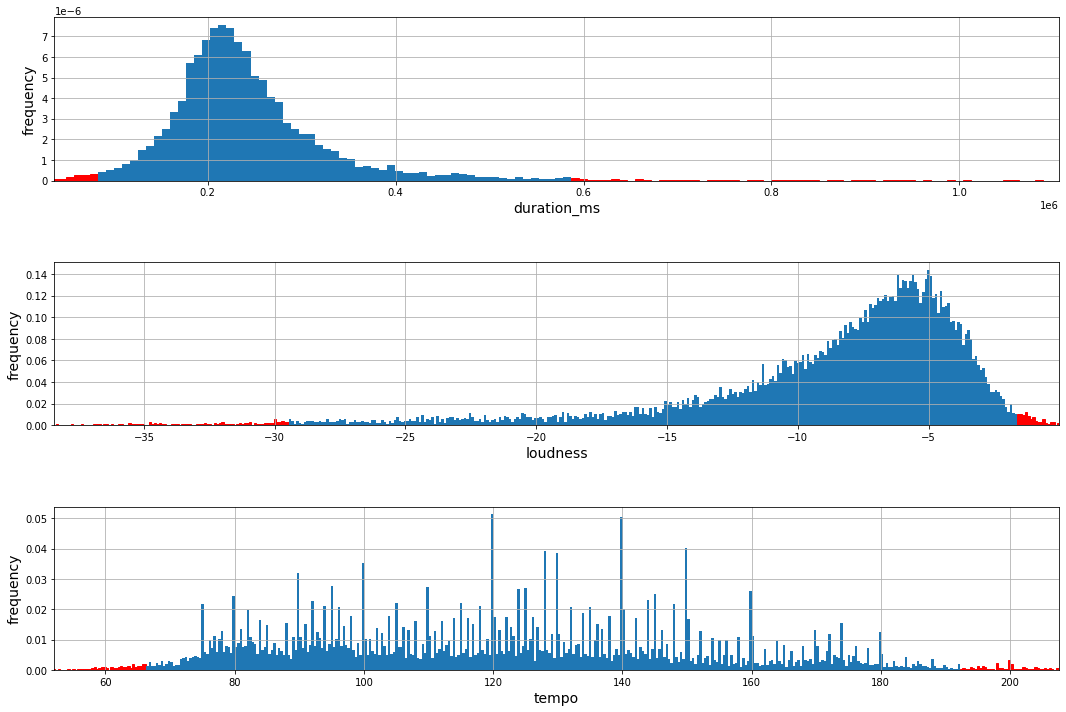

In [27]:
fig = plt.figure()
plt.subplots_adjust(hspace=0.5)

for i, col in enumerate(['duration_ms', 'loudness', 'tempo']):
    data = train_data[col]
    ax = fig.add_subplot(3, 1, i + 1)
    lower = data.quantile(0.01)
    higher = data.quantile(0.99)
    
    data.plot(kind='hist', bins=500, density=True, grid=True, xlim=(data.quantile(0.001), data.quantile(0.999)))
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('frequency', fontsize=14)
    
    for rect in ax.patches:
        if rect.get_x() < lower or higher < rect.get_x():
            rect.set_color('red')
    
    #train_data = train_data[(train_data[col].isna()) | ((q1 <= train_data[col]) & (train_data[col] <= q2))]

In [23]:
# TODO
# добавить скалирование
# добавить фильтрацию аномальных значений в столбцах `duration_ms`, `loudness`, `tempo`. Пояснить, почему в других столбцах она не требуется
# добавить анализ зависимостей целевого признака от остальных признаков

## Разведочный анализ данных

Создадим копию тренировочных данных без кодирования. Будем использовать её для анализа данных, а сам тренировочный набор данных для обучения моделей

In [24]:
decoded_train = train_data.copy()
decoded_train[categorical] = encoder.inverse_transform(decoded_train.copy()[categorical])

Проанализируем дисбаланс классов в целевом признаке

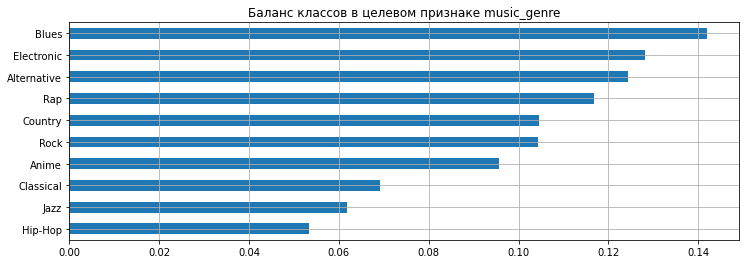

In [25]:
decoded_train.music_genre.value_counts(normalize=True).sort_values(ascending=True).plot(kind='barh', 
                                                                                        figsize=(12, 4),
                                                                                        title='Баланс классов в целевом признаке music_genre',
                                                                                        legend=False,
                                                                                        grid=True);
decoded_train.music_genre.value_counts(normalize=True).plot(kind='pie',
                                                            figsize=(12, 4),
                                                            autopct='%1.1f%%',
                                                            title='Cоотношение пользователей с подпиской и без подписки',
                                                            shadow=True,
                                                            grid=True);

plt.xticks(rotation=360);

Отобразим частоту содержания музыкального жанра в названии музыкального трека в качестве подстроки

In [26]:
genre_freq = decoded_train.genre_from_name.value_counts().reindex(decoded_train.music_genre.unique(), fill_value=0).sort_values(ascending=False)
genre_freq

Blues          96
Rock           54
Country        52
Jazz            8
Rap             3
Anime           2
Electronic      1
Classical       1
Hip-Hop         0
Alternative     0
Name: genre_from_name, dtype: int64

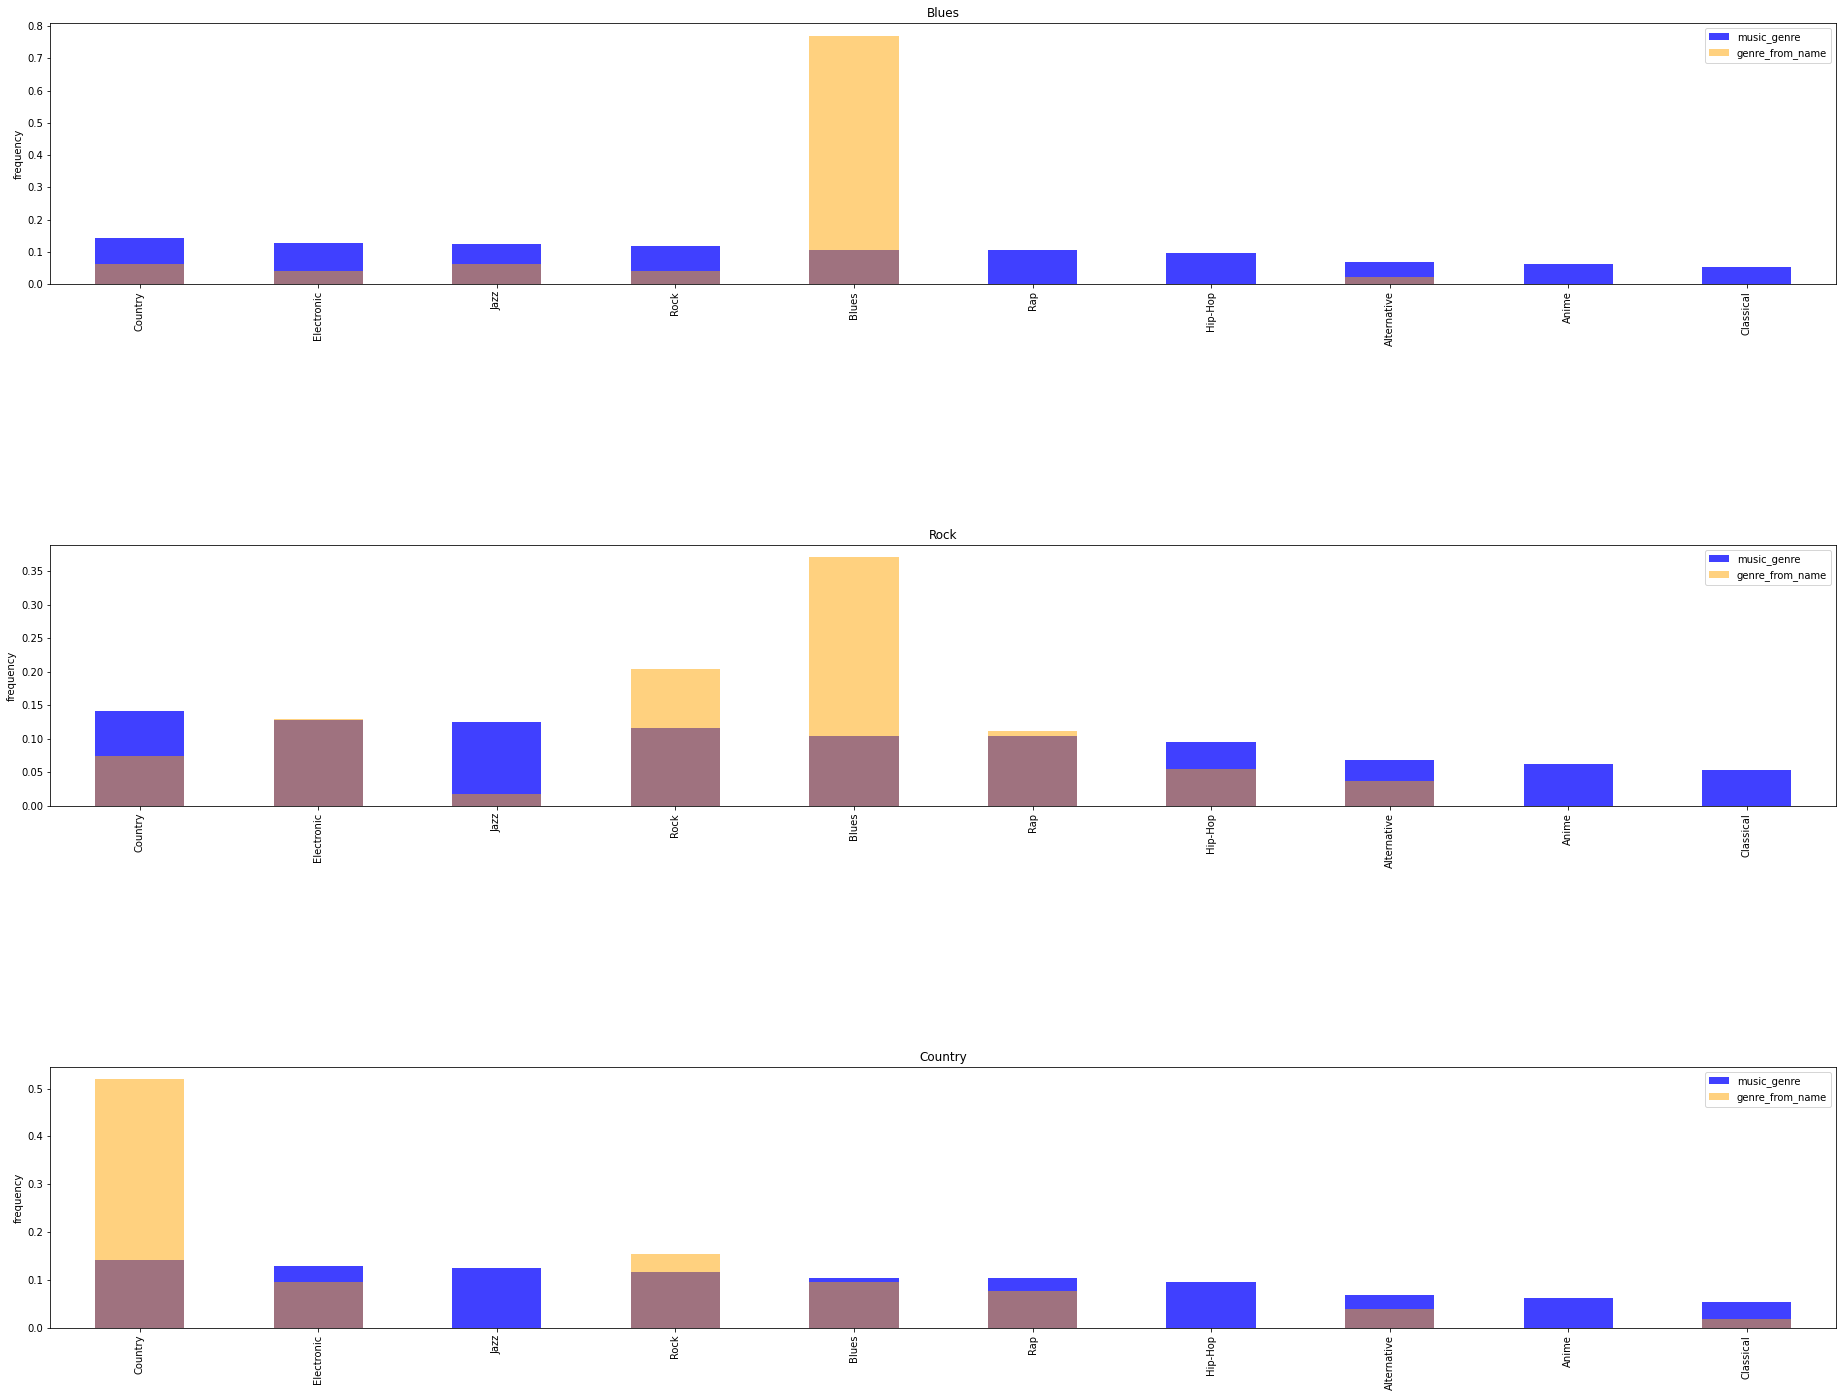

In [27]:
fig = plt.figure(figsize=(32, 24))
plt.subplots_adjust(hspace=1.0)

for i, genre in enumerate(genre_freq[genre_freq >= 30].index):
    ax = fig.add_subplot(3, 1, i + 1)
    (decoded_train
     .music_genre
     .value_counts(normalize=True)
     .plot(kind='bar', ax=ax, color='blue', alpha=0.75, figsize=(32, 24))
    )
    (decoded_train[decoded_train.genre_from_name == genre]
     .music_genre
     .value_counts(normalize=True).reindex(decoded_train.music_genre.unique(), fill_value=0)
     .plot(kind='bar', ax=ax, color='orange', alpha=0.5, figsize=(32, 24))
    )
    ax.set_title(genre)
    ax.set_xlabel(None)
    ax.set_ylabel('frequency')
    ax.legend(['music_genre', 'genre_from_name'])

Из небольшого исследования проведённого выше можно сформулировать гипотезу о том, что новый признак `genre_from_name` может быть полезным в прогнозировании музыкального жанра

## Выбор и обучение моделей

In [9]:
dummy_model = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dummy_model.fit(train_features, train_target)
dummy_predictions = dummy_model.predict(valid_features)
print(f'Значение F-beta для наивной модели на тестовых данных — {fbeta_score(valid_target, dummy_predictions, beta=0.5, average="weighted")}')

NameError: name 'train_features' is not defined

In [29]:
tree_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                                 param_distributions={
                                     'criterion': ['gini', 'entropy'],
                                     'max_depth': list(range(1, 51)),
                                     'min_samples_split': list(range(2, 12))
                                 },
                                 n_iter=200,
                                 n_jobs=-1,
                                 cv=5,
                                 verbose=10).fit(train_features, train_target)
forest_search = RandomizedSearchCV(RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'),
                                   param_distributions={
                                       'criterion': ['gini', 'entropy'],
                                       'max_depth': list(range(1, 51)),
                                       'n_estimators': list(range(1, 101)),
                                   },
                                   n_iter= 200,
                                   n_jobs=-1,
                                   cv=5,
                                   verbose=10).fit(train_features, train_target)
boosting_search = RandomizedSearchCV(GradientBoostingClassifier(random_state=RANDOM_STATE),
                                     param_distributions={
                                         'max_depth': list(range(1, 11)),
                                         'learning_rate': [0.01, 0.05, 0.1, 0.25],
                                         'n_estimators': list(range(1, 101)),
                                         'min_samples_split': list(range(2, 12))
                                     },
                                     n_iter=200,
                                     n_jobs=-1,
                                     cv=5,
                                     verbose=10).fit(train_features, train_target)

Fitting 4 folds for each of 100 candidates, totalling 400 fits
[CV 1/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 1/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.354 total time=   0.4s
[CV 2/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 2/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.358 total time=   0.4s
[CV 3/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 3/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.363 total time=   0.4s
[CV 4/4; 1/100] START criterion=entropy, max_depth=38, min_samples_split=3......
[CV 4/4; 1/100] END criterion=entropy, max_depth=38, min_samples_split=3;, score=0.362 total time=   0.4s
[CV 1/4; 2/100] START criterion=entropy, max_depth=32, min_samples_split=10.....
[CV 1/4; 2/100] END criterion=entropy, max_depth=32, min_samples_split=10;, score=0.351 total time=   0.4s
[

[CV 1/4; 13/100] END criterion=gini, max_depth=11, min_samples_split=3;, score=0.398 total time=   0.2s
[CV 2/4; 13/100] START criterion=gini, max_depth=11, min_samples_split=3........
[CV 2/4; 13/100] END criterion=gini, max_depth=11, min_samples_split=3;, score=0.396 total time=   0.2s
[CV 3/4; 13/100] START criterion=gini, max_depth=11, min_samples_split=3........
[CV 3/4; 13/100] END criterion=gini, max_depth=11, min_samples_split=3;, score=0.388 total time=   0.2s
[CV 4/4; 13/100] START criterion=gini, max_depth=11, min_samples_split=3........
[CV 4/4; 13/100] END criterion=gini, max_depth=11, min_samples_split=3;, score=0.399 total time=   0.2s
[CV 1/4; 14/100] START criterion=entropy, max_depth=46, min_samples_split=8.....
[CV 1/4; 14/100] END criterion=entropy, max_depth=46, min_samples_split=8;, score=0.349 total time=   0.5s
[CV 2/4; 14/100] START criterion=entropy, max_depth=46, min_samples_split=8.....
[CV 2/4; 14/100] END criterion=entropy, max_depth=46, min_samples_split=

[CV 1/4; 24/100] END criterion=entropy, max_depth=43, min_samples_split=10;, score=0.351 total time=   0.4s
[CV 2/4; 24/100] START criterion=entropy, max_depth=43, min_samples_split=10....
[CV 2/4; 24/100] END criterion=entropy, max_depth=43, min_samples_split=10;, score=0.356 total time=   0.4s
[CV 3/4; 24/100] START criterion=entropy, max_depth=43, min_samples_split=10....
[CV 3/4; 24/100] END criterion=entropy, max_depth=43, min_samples_split=10;, score=0.368 total time=   0.4s
[CV 4/4; 24/100] START criterion=entropy, max_depth=43, min_samples_split=10....
[CV 4/4; 24/100] END criterion=entropy, max_depth=43, min_samples_split=10;, score=0.366 total time=   0.4s
[CV 1/4; 25/100] START criterion=gini, max_depth=35, min_samples_split=2........
[CV 1/4; 25/100] END criterion=gini, max_depth=35, min_samples_split=2;, score=0.357 total time=   0.3s
[CV 2/4; 25/100] START criterion=gini, max_depth=35, min_samples_split=2........
[CV 2/4; 25/100] END criterion=gini, max_depth=35, min_samp

[CV 1/4; 35/100] END criterion=gini, max_depth=28, min_samples_split=9;, score=0.356 total time=   0.3s
[CV 2/4; 35/100] START criterion=gini, max_depth=28, min_samples_split=9........
[CV 2/4; 35/100] END criterion=gini, max_depth=28, min_samples_split=9;, score=0.361 total time=   0.3s
[CV 3/4; 35/100] START criterion=gini, max_depth=28, min_samples_split=9........
[CV 3/4; 35/100] END criterion=gini, max_depth=28, min_samples_split=9;, score=0.360 total time=   0.3s
[CV 4/4; 35/100] START criterion=gini, max_depth=28, min_samples_split=9........
[CV 4/4; 35/100] END criterion=gini, max_depth=28, min_samples_split=9;, score=0.372 total time=   0.3s
[CV 1/4; 36/100] START criterion=entropy, max_depth=3, min_samples_split=7......
[CV 1/4; 36/100] END criterion=entropy, max_depth=3, min_samples_split=7;, score=0.288 total time=   0.1s
[CV 2/4; 36/100] START criterion=entropy, max_depth=3, min_samples_split=7......
[CV 2/4; 36/100] END criterion=entropy, max_depth=3, min_samples_split=7;

[CV 2/4; 46/100] END criterion=gini, max_depth=17, min_samples_split=4;, score=0.367 total time=   0.3s
[CV 3/4; 46/100] START criterion=gini, max_depth=17, min_samples_split=4........
[CV 3/4; 46/100] END criterion=gini, max_depth=17, min_samples_split=4;, score=0.360 total time=   0.3s
[CV 4/4; 46/100] START criterion=gini, max_depth=17, min_samples_split=4........
[CV 4/4; 46/100] END criterion=gini, max_depth=17, min_samples_split=4;, score=0.376 total time=   0.3s
[CV 1/4; 47/100] START criterion=gini, max_depth=20, min_samples_split=9........
[CV 1/4; 47/100] END criterion=gini, max_depth=20, min_samples_split=9;, score=0.362 total time=   0.3s
[CV 2/4; 47/100] START criterion=gini, max_depth=20, min_samples_split=9........
[CV 2/4; 47/100] END criterion=gini, max_depth=20, min_samples_split=9;, score=0.366 total time=   0.3s
[CV 3/4; 47/100] START criterion=gini, max_depth=20, min_samples_split=9........
[CV 3/4; 47/100] END criterion=gini, max_depth=20, min_samples_split=9;, sc

[CV 4/4; 57/100] END criterion=entropy, max_depth=5, min_samples_split=4;, score=0.350 total time=   0.2s
[CV 1/4; 58/100] START criterion=entropy, max_depth=24, min_samples_split=6.....
[CV 1/4; 58/100] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.348 total time=   0.4s
[CV 2/4; 58/100] START criterion=entropy, max_depth=24, min_samples_split=6.....
[CV 2/4; 58/100] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.354 total time=   0.4s
[CV 3/4; 58/100] START criterion=entropy, max_depth=24, min_samples_split=6.....
[CV 3/4; 58/100] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.358 total time=   0.4s
[CV 4/4; 58/100] START criterion=entropy, max_depth=24, min_samples_split=6.....
[CV 4/4; 58/100] END criterion=entropy, max_depth=24, min_samples_split=6;, score=0.362 total time=   0.4s
[CV 1/4; 59/100] START criterion=entropy, max_depth=37, min_samples_split=4.....
[CV 1/4; 59/100] END criterion=entropy, max_depth=37, min_sam

[CV 4/4; 68/100] END criterion=gini, max_depth=24, min_samples_split=4;, score=0.364 total time=   0.3s
[CV 1/4; 69/100] START criterion=entropy, max_depth=31, min_samples_split=6.....
[CV 1/4; 69/100] END criterion=entropy, max_depth=31, min_samples_split=6;, score=0.350 total time=   0.5s
[CV 2/4; 69/100] START criterion=entropy, max_depth=31, min_samples_split=6.....
[CV 2/4; 69/100] END criterion=entropy, max_depth=31, min_samples_split=6;, score=0.356 total time=   0.4s
[CV 3/4; 69/100] START criterion=entropy, max_depth=31, min_samples_split=6.....
[CV 3/4; 69/100] END criterion=entropy, max_depth=31, min_samples_split=6;, score=0.356 total time=   0.4s
[CV 4/4; 69/100] START criterion=entropy, max_depth=31, min_samples_split=6.....
[CV 4/4; 69/100] END criterion=entropy, max_depth=31, min_samples_split=6;, score=0.362 total time=   0.4s
[CV 1/4; 70/100] START criterion=entropy, max_depth=27, min_samples_split=3.....
[CV 1/4; 70/100] END criterion=entropy, max_depth=27, min_sampl

[CV 1/4; 80/100] END criterion=gini, max_depth=33, min_samples_split=8;, score=0.357 total time=   0.3s
[CV 2/4; 80/100] START criterion=gini, max_depth=33, min_samples_split=8........
[CV 2/4; 80/100] END criterion=gini, max_depth=33, min_samples_split=8;, score=0.359 total time=   0.3s
[CV 3/4; 80/100] START criterion=gini, max_depth=33, min_samples_split=8........
[CV 3/4; 80/100] END criterion=gini, max_depth=33, min_samples_split=8;, score=0.360 total time=   0.3s
[CV 4/4; 80/100] START criterion=gini, max_depth=33, min_samples_split=8........
[CV 4/4; 80/100] END criterion=gini, max_depth=33, min_samples_split=8;, score=0.370 total time=   0.3s
[CV 1/4; 81/100] START criterion=gini, max_depth=12, min_samples_split=3........
[CV 1/4; 81/100] END criterion=gini, max_depth=12, min_samples_split=3;, score=0.400 total time=   0.2s
[CV 2/4; 81/100] START criterion=gini, max_depth=12, min_samples_split=3........
[CV 2/4; 81/100] END criterion=gini, max_depth=12, min_samples_split=3;, sc

[CV 1/4; 91/100] END criterion=entropy, max_depth=40, min_samples_split=7;, score=0.353 total time=   0.4s
[CV 2/4; 91/100] START criterion=entropy, max_depth=40, min_samples_split=7.....
[CV 2/4; 91/100] END criterion=entropy, max_depth=40, min_samples_split=7;, score=0.353 total time=   0.5s
[CV 3/4; 91/100] START criterion=entropy, max_depth=40, min_samples_split=7.....
[CV 3/4; 91/100] END criterion=entropy, max_depth=40, min_samples_split=7;, score=0.358 total time=   0.5s
[CV 4/4; 91/100] START criterion=entropy, max_depth=40, min_samples_split=7.....
[CV 4/4; 91/100] END criterion=entropy, max_depth=40, min_samples_split=7;, score=0.363 total time=   0.4s
[CV 1/4; 92/100] START criterion=entropy, max_depth=22, min_samples_split=7.....
[CV 1/4; 92/100] END criterion=entropy, max_depth=22, min_samples_split=7;, score=0.349 total time=   0.4s
[CV 2/4; 92/100] START criterion=entropy, max_depth=22, min_samples_split=7.....
[CV 2/4; 92/100] END criterion=entropy, max_depth=22, min_sa

[CV 1/4; 2/100] END criterion=entropy, max_depth=29, n_estimators=27;, score=0.463 total time=   1.8s
[CV 2/4; 2/100] START criterion=entropy, max_depth=29, n_estimators=27..........
[CV 2/4; 2/100] END criterion=entropy, max_depth=29, n_estimators=27;, score=0.473 total time=   1.8s
[CV 3/4; 2/100] START criterion=entropy, max_depth=29, n_estimators=27..........
[CV 3/4; 2/100] END criterion=entropy, max_depth=29, n_estimators=27;, score=0.472 total time=   1.9s
[CV 4/4; 2/100] START criterion=entropy, max_depth=29, n_estimators=27..........
[CV 4/4; 2/100] END criterion=entropy, max_depth=29, n_estimators=27;, score=0.470 total time=   1.8s
[CV 1/4; 3/100] START criterion=entropy, max_depth=37, n_estimators=22..........
[CV 1/4; 3/100] END criterion=entropy, max_depth=37, n_estimators=22;, score=0.460 total time=   1.4s
[CV 2/4; 3/100] START criterion=entropy, max_depth=37, n_estimators=22..........
[CV 2/4; 3/100] END criterion=entropy, max_depth=37, n_estimators=22;, score=0.474 to

[CV 3/4; 13/100] END criterion=gini, max_depth=20, n_estimators=9;, score=0.434 total time=   0.4s
[CV 4/4; 13/100] START criterion=gini, max_depth=20, n_estimators=9.............
[CV 4/4; 13/100] END criterion=gini, max_depth=20, n_estimators=9;, score=0.446 total time=   0.4s
[CV 1/4; 14/100] START criterion=gini, max_depth=38, n_estimators=48............
[CV 1/4; 14/100] END criterion=gini, max_depth=38, n_estimators=48;, score=0.485 total time=   2.0s
[CV 2/4; 14/100] START criterion=gini, max_depth=38, n_estimators=48............
[CV 2/4; 14/100] END criterion=gini, max_depth=38, n_estimators=48;, score=0.499 total time=   1.9s
[CV 3/4; 14/100] START criterion=gini, max_depth=38, n_estimators=48............
[CV 3/4; 14/100] END criterion=gini, max_depth=38, n_estimators=48;, score=0.491 total time=   2.0s
[CV 4/4; 14/100] START criterion=gini, max_depth=38, n_estimators=48............
[CV 4/4; 14/100] END criterion=gini, max_depth=38, n_estimators=48;, score=0.484 total time=   1.

[CV 1/4; 25/100] END criterion=gini, max_depth=2, n_estimators=62;, score=0.323 total time=   0.4s
[CV 2/4; 25/100] START criterion=gini, max_depth=2, n_estimators=62.............
[CV 2/4; 25/100] END criterion=gini, max_depth=2, n_estimators=62;, score=0.327 total time=   0.4s
[CV 3/4; 25/100] START criterion=gini, max_depth=2, n_estimators=62.............
[CV 3/4; 25/100] END criterion=gini, max_depth=2, n_estimators=62;, score=0.320 total time=   0.4s
[CV 4/4; 25/100] START criterion=gini, max_depth=2, n_estimators=62.............
[CV 4/4; 25/100] END criterion=gini, max_depth=2, n_estimators=62;, score=0.318 total time=   0.4s
[CV 1/4; 26/100] START criterion=gini, max_depth=45, n_estimators=13............
[CV 1/4; 26/100] END criterion=gini, max_depth=45, n_estimators=13;, score=0.439 total time=   0.5s
[CV 2/4; 26/100] START criterion=gini, max_depth=45, n_estimators=13............
[CV 2/4; 26/100] END criterion=gini, max_depth=45, n_estimators=13;, score=0.457 total time=   0.6s

[CV 2/4; 36/100] END criterion=gini, max_depth=37, n_estimators=69;, score=0.499 total time=   2.9s
[CV 3/4; 36/100] START criterion=gini, max_depth=37, n_estimators=69............
[CV 3/4; 36/100] END criterion=gini, max_depth=37, n_estimators=69;, score=0.496 total time=   2.8s
[CV 4/4; 36/100] START criterion=gini, max_depth=37, n_estimators=69............
[CV 4/4; 36/100] END criterion=gini, max_depth=37, n_estimators=69;, score=0.490 total time=   3.0s
[CV 1/4; 37/100] START criterion=gini, max_depth=15, n_estimators=17............
[CV 1/4; 37/100] END criterion=gini, max_depth=15, n_estimators=17;, score=0.460 total time=   0.6s
[CV 2/4; 37/100] START criterion=gini, max_depth=15, n_estimators=17............
[CV 2/4; 37/100] END criterion=gini, max_depth=15, n_estimators=17;, score=0.466 total time=   0.6s
[CV 3/4; 37/100] START criterion=gini, max_depth=15, n_estimators=17............
[CV 3/4; 37/100] END criterion=gini, max_depth=15, n_estimators=17;, score=0.474 total time=   

[CV 3/4; 47/100] END criterion=gini, max_depth=17, n_estimators=84;, score=0.497 total time=   3.1s
[CV 4/4; 47/100] START criterion=gini, max_depth=17, n_estimators=84............
[CV 4/4; 47/100] END criterion=gini, max_depth=17, n_estimators=84;, score=0.491 total time=   3.2s
[CV 1/4; 48/100] START criterion=gini, max_depth=13, n_estimators=58............
[CV 1/4; 48/100] END criterion=gini, max_depth=13, n_estimators=58;, score=0.479 total time=   1.9s
[CV 2/4; 48/100] START criterion=gini, max_depth=13, n_estimators=58............
[CV 2/4; 48/100] END criterion=gini, max_depth=13, n_estimators=58;, score=0.485 total time=   1.9s
[CV 3/4; 48/100] START criterion=gini, max_depth=13, n_estimators=58............
[CV 3/4; 48/100] END criterion=gini, max_depth=13, n_estimators=58;, score=0.489 total time=   1.9s
[CV 4/4; 48/100] START criterion=gini, max_depth=13, n_estimators=58............
[CV 4/4; 48/100] END criterion=gini, max_depth=13, n_estimators=58;, score=0.471 total time=   

[CV 1/4; 59/100] END criterion=gini, max_depth=42, n_estimators=69;, score=0.490 total time=   3.3s
[CV 2/4; 59/100] START criterion=gini, max_depth=42, n_estimators=69............
[CV 2/4; 59/100] END criterion=gini, max_depth=42, n_estimators=69;, score=0.496 total time=   3.2s
[CV 3/4; 59/100] START criterion=gini, max_depth=42, n_estimators=69............
[CV 3/4; 59/100] END criterion=gini, max_depth=42, n_estimators=69;, score=0.496 total time=   3.1s
[CV 4/4; 59/100] START criterion=gini, max_depth=42, n_estimators=69............
[CV 4/4; 59/100] END criterion=gini, max_depth=42, n_estimators=69;, score=0.489 total time=   3.0s
[CV 1/4; 60/100] START criterion=entropy, max_depth=46, n_estimators=99.........
[CV 1/4; 60/100] END criterion=entropy, max_depth=46, n_estimators=99;, score=0.492 total time=   7.3s
[CV 2/4; 60/100] START criterion=entropy, max_depth=46, n_estimators=99.........
[CV 2/4; 60/100] END criterion=entropy, max_depth=46, n_estimators=99;, score=0.497 total ti

[CV 2/4; 70/100] END criterion=gini, max_depth=45, n_estimators=73;, score=0.500 total time=   3.0s
[CV 3/4; 70/100] START criterion=gini, max_depth=45, n_estimators=73............
[CV 3/4; 70/100] END criterion=gini, max_depth=45, n_estimators=73;, score=0.497 total time=   3.0s
[CV 4/4; 70/100] START criterion=gini, max_depth=45, n_estimators=73............
[CV 4/4; 70/100] END criterion=gini, max_depth=45, n_estimators=73;, score=0.491 total time=   3.0s
[CV 1/4; 71/100] START criterion=gini, max_depth=43, n_estimators=59............
[CV 1/4; 71/100] END criterion=gini, max_depth=43, n_estimators=59;, score=0.490 total time=   2.5s
[CV 2/4; 71/100] START criterion=gini, max_depth=43, n_estimators=59............
[CV 2/4; 71/100] END criterion=gini, max_depth=43, n_estimators=59;, score=0.498 total time=   2.5s
[CV 3/4; 71/100] START criterion=gini, max_depth=43, n_estimators=59............
[CV 3/4; 71/100] END criterion=gini, max_depth=43, n_estimators=59;, score=0.489 total time=   

[CV 4/4; 81/100] END criterion=gini, max_depth=44, n_estimators=14;, score=0.448 total time=   0.6s
[CV 1/4; 82/100] START criterion=gini, max_depth=11, n_estimators=54............
[CV 1/4; 82/100] END criterion=gini, max_depth=11, n_estimators=54;, score=0.477 total time=   1.5s
[CV 2/4; 82/100] START criterion=gini, max_depth=11, n_estimators=54............
[CV 2/4; 82/100] END criterion=gini, max_depth=11, n_estimators=54;, score=0.470 total time=   1.6s
[CV 3/4; 82/100] START criterion=gini, max_depth=11, n_estimators=54............
[CV 3/4; 82/100] END criterion=gini, max_depth=11, n_estimators=54;, score=0.471 total time=   1.5s
[CV 4/4; 82/100] START criterion=gini, max_depth=11, n_estimators=54............
[CV 4/4; 82/100] END criterion=gini, max_depth=11, n_estimators=54;, score=0.468 total time=   1.5s
[CV 1/4; 83/100] START criterion=gini, max_depth=12, n_estimators=52............
[CV 1/4; 83/100] END criterion=gini, max_depth=12, n_estimators=52;, score=0.487 total time=   

[CV 2/4; 93/100] END criterion=gini, max_depth=38, n_estimators=90;, score=0.503 total time=   3.9s
[CV 3/4; 93/100] START criterion=gini, max_depth=38, n_estimators=90............
[CV 3/4; 93/100] END criterion=gini, max_depth=38, n_estimators=90;, score=0.500 total time=   4.0s
[CV 4/4; 93/100] START criterion=gini, max_depth=38, n_estimators=90............
[CV 4/4; 93/100] END criterion=gini, max_depth=38, n_estimators=90;, score=0.496 total time=   4.0s
[CV 1/4; 94/100] START criterion=entropy, max_depth=18, n_estimators=35.........
[CV 1/4; 94/100] END criterion=entropy, max_depth=18, n_estimators=35;, score=0.480 total time=   2.3s
[CV 2/4; 94/100] START criterion=entropy, max_depth=18, n_estimators=35.........
[CV 2/4; 94/100] END criterion=entropy, max_depth=18, n_estimators=35;, score=0.477 total time=   2.4s
[CV 3/4; 94/100] START criterion=entropy, max_depth=18, n_estimators=35.........
[CV 3/4; 94/100] END criterion=entropy, max_depth=18, n_estimators=35;, score=0.481 total

In [33]:
predictions = tree_search.predict(valid_features)
fbeta_score(valid_target, predictions, beta=0.5, average='weighted')

0.39896040067501587

In [34]:
predictions = forest_search.predict(valid_features)
fbeta_score(valid_target, predictions, beta=0.5, average='weighted')

0.47644560813363523

In [35]:
predictions = boosting_search.predict(valid_features)
fbeta_score(valid_target, predictions, beta=0.5, average='weighted')

0.48630974649736264

In [37]:
pd.DataFrame(boosting_search.predict(test_data), columns=['music_genre'], index=pd.read_csv('./test_updated.csv').instance_id).to_csv('./sample_submit1.csv')

# Дальше мусор (не успел доделать до конца)

In [ ]:
#print('Среднее значение столбца days_exposition:', data.days_exposition.mean())
#print('Медианное значение столбца days_exposition:', data.days_exposition.median())
#print('Модальное значение столбца days_exposition:', data.days_exposition.mode()[0])


In [ ]:
#for column in ['kitchen_area', 'living_area', 'total_area']:
#    (
#        data.pivot_table(index='last_price', values=column, aggfunc='mean')
#        .reset_index()
#        .plot(kind='scatter',
#              x='last_price',
#              y=column,
#              xlim=(0, 50000000),
#              figsize=(12, 4),
#              title=column,
#              legend=True,
#              grid=True)
#    )
#    plt.show()

Ранее мы изучили следующие модели: дерево решений, случайный лес, градиентный бустинг.

Рассмотрим изученные нами ранее метрики для задачи классификации — `accuracy`, `precision`, `recall`, `F1-score`, `ROC-AUC`:
- Известно, что `accuracy` зачастую не является оптимальным выбором в качестве метрики для проблем с дисбалансом классов
- Для нашей задачи важно минимизировать как `False Positive` так и `False Negative` предсказания модели. В самом деле, если модель ложно спрогнозировала отказ от брони и обязала клиента внести депозит (хотя на самом деле он ни в коем случае не собирался делать отмену) то он может и вовсе отказаться от предоставленных услуг и по итогу сеть потеряет очередного клиента. И наоборот, если модель не смогла спрогнозировать отказ от бронирования, то сеть в таком случае может потерпеть убытки. Поэтому мы не будем делать предпочтения на счёт выбора между `precision` и `recall` и остановимся на двух метриках — `F1-score` и `ROC-AUC`
- Метрику `F1-score` легче интерпретировать и объяснить её использование для бизнеса, чем метрику `ROC-AUC` поэтому будем использовать её в качестве основной метрики при выборе оптимальной модели. Тем не менее мы дополнительно посмотрим на кривую `ROC` и подсчитаем площадь по ней — `ROC-AUC` для наилучшей модели

Для борьбы с дисбалансом классов будем использовать параметр `class_weight`

In [ ]:
# check
#data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter',
#        y='last_price' , x='total_area', alpha=0.5, subplots=True, figsize=(15,8), c = 'b', s = 4)
#plt.title('Диаграмма рассеяния — Общая площадь — цена трешки')


#data[data['rooms'] == 3].query('total_area < 201 and last_price < 25_000_000').plot(kind='scatter', 
#        y='last_price' , x='living_area', alpha=0.5, figsize=(15,8), c = 'r', s = 4)
#plt.title('Диаграмма рассеяния — Жилая площадь — цена трешки');

In [ ]:
probabilities_one_valid = forest_search.best_estimator_.predict_proba(valid_features)[:, 1]
fpr, tpr, thresholds = roc_curve(valid_target, probabilities_one_valid)

plt.figure()
# ROC-кривая наулучшей модели RandomForestClassifier на тестовой выборке
plt.plot(fpr, tpr)

# ROC-кривая случайной модели (выглядит как прямая)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim(0, 1.0)
plt.ylim(0, 1.0)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

print(f'Площадь под ROC-кривой наулучшей модели RandomForestClassifier (AUC-ROC) равна — {roc_auc_score(valid_target, probabilities_one_valid)}')

In [ ]:
sns.pairplot(data[['last_price', 'total_area', 'rooms', 'city_centers_nearest']])
plt.gcf().set_size_inches(12,12);

## Итоговая оценка качества предсказания лучшей модели

## Общий вывод

**1) Загрузка и ознакомление с данными:** \
**2) Предварительная обработка:** \
**3) Исследовательский анализ данных:** \
**4) Выбор и обучение моделей:** \
**5) Итоговая оценка качества предсказания лучшей модели:**